# Sieci neuronowe

## Wstęp

Celem laboratorium jest zapoznanie się z podstawami sieci neuronowych oraz uczeniem głębokim (*deep learning*). Zapoznasz się na nim z następującymi tematami:
- treningiem prostych sieci neuronowych, w szczególności z:
  - regresją liniową w sieciach neuronowych
  - optymalizacją funkcji kosztu
  - algorytmem spadku wzdłuż gradientu
  - siecią typu Multilayer Perceptron (MLP)
- frameworkiem PyTorch, w szczególności z:
  - ładowaniem danych
  - preprocessingiem danych
  - pisaniem pętli treningowej i walidacyjnej
  - walidacją modeli
- architekturą i hiperaprametrami sieci MLP, w szczególności z:
  - warstwami gęstymi (w pełni połączonymi)
  - funkcjami aktywacji
  - regularyzacją: L2, dropout

## Wykorzystywane biblioteki

Zaczniemy od pisania ręcznie prostych sieci w bibliotece Numpy, służącej do obliczeń numerycznych na CPU. Później przejdziemy do wykorzystywania frameworka PyTorch, służącego do obliczeń numerycznych na CPU, GPU oraz automatycznego różniczkowania, wykorzystywanego głównie do treningu sieci neuronowych.

Wykorzystamy PyTorcha ze względu na popularność, łatwość instalacji i użycia, oraz dużą kontrolę nad niskopoziomowymi aspektami budowy i treningu sieci neuronowych. Framework ten został stworzony do zastosowań badawczych i naukowych, ale ze względu na wygodę użycia stał się bardzo popularny także w przemyśle. W szczególności całkowicie zdominował przetwarzanie języka naturalnego (NLP) oraz uczenie na grafach.

Pierwszy duży framework do deep learningu, oraz obecnie najpopularniejszy, to TensorFlow, wraz z wysokopoziomową nakładką Keras. Są jednak szanse, że Google (autorzy) będzie go powoli porzucać na rzecz ich nowego frameworka JAX ([dyskusja](https://www.reddit.com/r/MachineLearning/comments/vfl57t/d_google_quietly_moving_its_products_from/), [artykuł Business Insidera](https://www.businessinsider.com/facebook-pytorch-beat-google-tensorflow-jax-meta-ai-2022-6?IR=T)), który jest bardzo świeżym, ale ciekawym narzędziem.

Trzecia, ale znacznie mniej popularna od powyższych opcja to Apache MXNet.

## Konfiguracja własnego komputera

Jeżeli korzystasz z własnego komputera, to musisz zainstalować trochę więcej bibliotek (Google Colab ma je już zainstalowane).

Jeżeli nie masz GPU lub nie chcesz z niego korzystać, to wystarczy znaleźć odpowiednią komendę CPU [na stronie PyTorcha](https://pytorch.org/get-started/locally/). Dla Anacondy odpowiednia komenda została podana poniżej, dla pip'a znajdź ją na stronie.

Jeżeli chcesz korzystać ze wsparcia GPU (na tym laboratorium nie będzie potrzebne, na kolejnych może przyspieszyć nieco obliczenia), to musi być to odpowiednio nowa karta NVidii, mająca CUDA compatibility ([lista](https://developer.nvidia.com/cuda-gpus)). Poza PyTorchem będzie potrzebne narzędzie NVidia CUDA w wersji 11.6 lub 11.7. Instalacja na Windowsie jest bardzo prosta (wystarczy ściągnąć plik EXE i zainstalować jak każdy inny program). Instalacja na Linuxie jest trudna i można względnie łatwo zepsuć sobie system, ale jeżeli chcesz spróbować, to [ten tutorial](https://www.youtube.com/results?search_query=nvidia+cuda+install+ubuntu+20.04) jest bardzo dobry.

## Wprowadzenie

Zanim zaczniemy naszą przygodę z sieciami neuronowymi, przyjrzyjmy się prostemu przykładowi regresji liniowej na syntetycznych danych:

In [2]:
from typing import Tuple, Dict

import numpy as np
import matplotlib.pyplot as plt

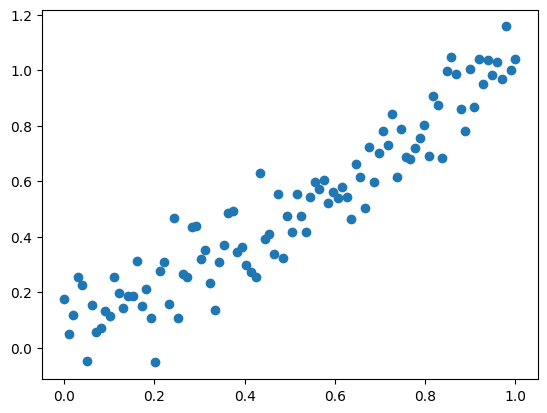

In [3]:
np.random.seed(0)

x = np.linspace(0, 1, 100)
y = x + np.random.normal(scale=0.1, size=x.shape)

plt.scatter(x, y)

W przeciwieństwie do laboratorium 1, tym razem będziemy chcieli rozwiązać ten problem własnoręcznie, bez użycia wysokopoziomowego interfejsu Scikit-learn'a. W tym celu musimy sobie przypomnieć sformułowanie naszego **problemu optymalizacyjnego (optimization problem)**.

W przypadku prostej regresji liniowej (1 zmienna) mamy model postaci $\hat{y} = \alpha x + \beta$, z dwoma parametrami, których będziemy się uczyć. Miarą niedopasowania modelu o danych parametrach jest **funkcja kosztu (cost function)**, nazywana też funkcją celu. Najczęściej używa się **błędu średniokwadratowego (mean squared error, MSE)**:
$$\large
MSE = \frac{1}{N} \sum_{i}^{N} (y - \hat{y})^2
$$

Od jakich $\alpha$ i $\beta$ zacząć? W najprostszym wypadku wystarczy po prostu je wylosować jako niewielkie liczby zmiennoprzecinkowe.

### Zadanie 1 (0.5 punkt)

Uzupełnij kod funkcji `mse`, obliczającej błąd średniokwadratowy. Wykorzystaj Numpy'a w celu wektoryzacji obliczeń dla wydajności.

In [4]:
def mse(y: np.ndarray, y_hat: np.ndarray) -> float:
    # implement me!
    # your_code
    diff = (y - y_hat)
    return (diff * diff).mean()


MSE: 0.133


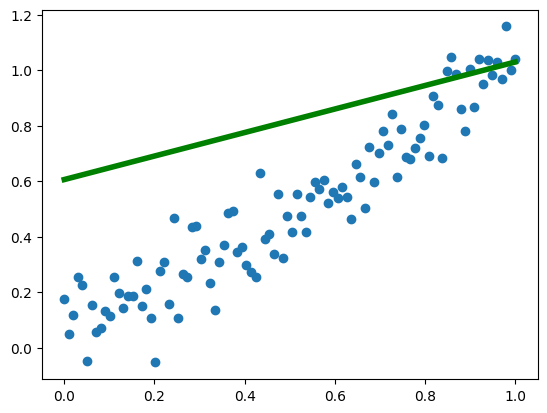

In [5]:
a = np.random.rand()
b = np.random.rand()
print(f"MSE: {mse(y, a * x + b):.3f}")

plt.scatter(x, y)
plt.plot(x, a * x + b, color="g", linewidth=4)

Losowe parametry radzą sobie nie najlepiej. Jak lepiej dopasować naszą prostą do danych? Zawsze możemy starać się wyprowadzić rozwiązanie analitycznie, i w tym wypadku nawet nam się uda. Jest to jednak szczególny i dość rzadki przypadek, a w szczególności nie będzie to możliwe w większych sieciach neuronowych.

Potrzebna nam będzie **metoda optymalizacji (optimization method)**, dającą wartości parametrów minimalizujące dowolną różniczkowalną funkcję kosztu. Zdecydowanie najpopularniejszy jest tutaj **spadek wzdłuż gradientu (gradient descent)**.

Metoda ta wywodzi się z prostych obserwacji, które tutaj przedstawimy. Bardziej szczegółowe rozwinięcie dla zainteresowanych: [sekcja 4.3 "Deep Learning Book"](https://www.deeplearningbook.org/contents/numerical.html), [ten praktyczny kurs](https://cs231n.github.io/optimization-1/), [analiza oryginalnej publikacji Cauchy'ego](https://www.math.uni-bielefeld.de/documenta/vol-ismp/40_lemarechal-claude.pdf) (oryginał w języku francuskim).

Pochodna jest dokładnie równa granicy funkcji. Dla małego $\epsilon$ można ją przybliżyć jako:
$$\large
\frac{f(x)}{dx} \approx \frac{f(x+\epsilon) - f(x)}{\epsilon}
$$

Przyglądając się temu równaniu widzimy, że: 
* dla funkcji rosnącej ($f(x+\epsilon) > f(x)$) wyrażenie $\frac{f(x)}{dx}$ będzie miało znak dodatni 
* dla funkcji malejącej ($f(x+\epsilon) < f(x)$) wyrażenie $\frac{f(x)}{dx}$ będzie miało znak ujemny 

Widzimy więc, że potrafimy wskazać kierunek zmniejszenia wartości funkcji, patrząc na znak pochodnej. Zaobserwowano także, że amplituda wartości w $\frac{f(x)}{dx}$ jest tym większa, im dalej jesteśmy od minimum (maximum). Pochodna wyznacza więc, w jakim kierunku funkcja najszybciej rośnie, zaś przeciwny zwrot to ten, w którym funkcja najszybciej spada.

Stosując powyższe do optymalizacji, mamy:
$$\large
x_{t+1} = x_{t} -  \alpha * \frac{f(x)}{dx}
$$

$\alpha$ to niewielka wartość (rzędu zwykle $10^{-5}$ - $10^{-2}$), wprowadzona, aby trzymać się założenia o małej zmianie parametrów ($\epsilon$). Nazywa się ją **stałą uczącą (learning rate)** i jest zwykle najważniejszym hiperparametrem podczas nauki sieci.

Metoda ta zakłada, że używamy całego zbioru danych do aktualizacji parametrów w każdym kroku, co nazywa się po prostu GD (od *gradient descent*) albo *full batch GD*. Wtedy każdy krok optymalizacji nazywa się **epoką (epoch)**.

Im większa stała ucząca, tym większe nasze kroki podczas minimalizacji. Możemy więc uczyć szybciej, ale istnieje ryzyko, że będziemy "przeskakiwać" minima. Mniejsza stała ucząca to wolniejszy, ale dokładniejszy trening. Jednak nie zawsze ona pozwala osiągnąć lepsze wyniki, bo może okazać się, że utkniemy w minimum lokalnym. Można także zmieniać stałą uczącą podczas treningu, co nazywa się **learning rate scheduling (LR scheduling)**. Obrazowo:

![learning_rate](http://www.bdhammel.com/assets/learning-rate/lr-types.png)

![interactive LR](http://cdn-images-1.medium.com/max/640/1*eeIvlwkMNG1wSmj3FR6M2g.gif)

Policzmy więc pochodną dla naszej funkcji kosztu MSE. Pochodną liczymy po parametrach naszego modelu, bo to właśnie ich chcemy dopasować tak, żeby koszt był jak najmniejszy:

$$\large
MSE = \frac{1}{N} \sum_{i}^{N} (y_i - \hat{y_i})^2
$$

W powyższym wzorze tylko $y_i$ jest zależny od $a$ oraz $b$. Możemy wykorzystać tu regułę łańcuchową (*chain rule*) i policzyć pochodne po naszych parametrach w sposób następujący:

$$\large
\frac{\text{d} MSE}{\text{d} a} = \frac{1}{N} \sum_{i}^{N} \frac{\text{d} (y_i - \hat{y_i})^2}{\text{d} \hat{y_i}} \frac{\text{d} \hat{y_i}}{\text{d} a}
$$

$$\large
\frac{\text{d} MSE}{\text{d} b} = \frac{1}{N} \sum_{i}^{N} \frac{\text{d} (y_i - \hat{y_i})^2}{\text{d} \hat{y_i}} \frac{\text{d} \hat{y_i}}{\text{d} b}
$$

Policzmy te pochodne po kolei:

$$\large
\frac{\text{d} (y_i - \hat{y_i})^2}{\text{d} \hat{y_i}} = -2 \cdot (y_i - \hat{y_i})
$$

$$\large
\frac{\text{d} \hat{y_i}}{\text{d} a} = x_i
$$

$$\large
\frac{\text{d} \hat{y_i}}{\text{d} b} = 1
$$

Łącząc powyższe wyniki dostaniemy:

$$\large
\frac{\text{d} MSE}{\text{d} a} = \frac{-2}{N} \sum_{i}^{N} (y_i - \hat{y_i}) \cdot {x_i}
$$

$$\large
\frac{\text{d} MSE}{\text{d} b} = \frac{-2}{N} \sum_{i}^{N} (y_i - \hat{y_i})
$$

Aktualizacja parametrów wygląda tak:

$$\large
a' = a - \alpha * \left( \frac{-2}{N} \sum_{i=1}^N (y_i - \hat{y}_i) \cdot x_i \right)
$$
$$\large
b' = b - \alpha * \left( \frac{-2}{N} \sum_{i=1}^N (y_i - \hat{y}_i) \right)
$$

Liczymy więc pochodną funkcji kosztu, a potem za pomocą reguły łańcuchowej "cofamy się", dochodząc do tego, jak każdy z parametrów wpływa na błąd i w jaki sposób powinniśmy go zmienić. Nazywa się to **propagacją wsteczną (backpropagation)** i jest podstawowym mechanizmem umożliwiającym naukę sieci neuronowych za pomocą spadku wzdłuż gradientu. Więcej możesz o tym przeczytać [tutaj](https://cs231n.github.io/optimization-2/).

### Zadanie 2 (1.0 punkt)

Zaimplementuj funkcję realizującą jedną epokę treningową. Zauważ, że `x` oraz `y` są wektorami. Oblicz predykcję przy aktualnych parametrach oraz zaktualizuj je zgodnie z powyższymi wzorami.

In [6]:
def optimize(
    x: np.ndarray, y: np.ndarray, a: float, b: float, learning_rate: float = 0.1
):
    N = len(y)
    y_hat = a * x + b
    errors = y - y_hat
    # implement me!
    # your_code
    new_a = a - learning_rate * (-2.0 / N * (errors * x).sum())
    new_b = b - learning_rate * (-2.0 / N * (errors).sum())

    return new_a, new_b


In [7]:
for i in range(1000):
    loss = mse(y, a * x + b)
    a, b = optimize(x, y, a, b)
    if i % 100 == 0:
        print(f"step {i} loss: ", loss)

print("final loss:", loss)

step 0 loss:  0.1330225119404028
step 100 loss:  0.012673197778527677
step 200 loss:  0.010257153540857817
step 300 loss:  0.0100948037549359
step 400 loss:  0.010083894412889118
step 500 loss:  0.010083161342973332
step 600 loss:  0.010083112083219709
step 700 loss:  0.010083108773135261
step 800 loss:  0.010083108550709076
step 900 loss:  0.01008310853576281
final loss: 0.010083108534760455


In [8]:
assert 0.0 < loss < 2.0

print("Solution is correct!")

Solution is correct!


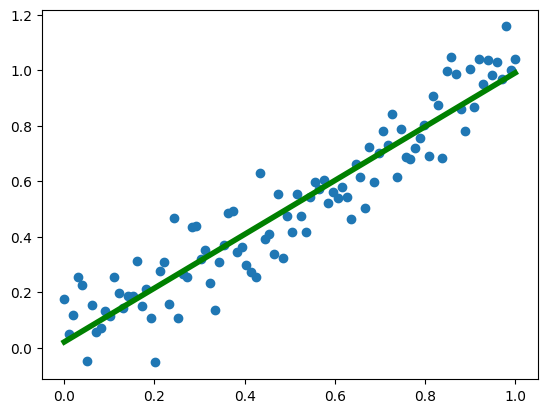

In [9]:
plt.scatter(x, y)
plt.plot(x, a * x + b, color="g", linewidth=4)

Udało ci się wytrenować swoją pierwszą sieć neuronową. Czemu? Otóż neuron to po prostu wektor parametrów, a zwykle robimy iloczyn skalarny tych parametrów z wejściem. Dodatkowo na wyjście nakłada się **funkcję aktywacji (activation function)**, która przekształca wyjście. Tutaj takiej nie było, a właściwie była to po prostu funkcja identyczności.

Oczywiście w praktyce korzystamy z odpowiedniego frameworka, który w szczególności:
- ułatwia budowanie sieci, np. ma gotowe klasy dla warstw neuronów
- ma zaimplementowane funkcje kosztu oraz ich pochodne
- sam różniczkuje ze względu na odpowiednie parametry i aktualizuje je odpowiednio podczas treningu


## Wprowadzenie do PyTorcha

PyTorch to w gruncie rzeczy narzędzie do algebry liniowej z [automatycznym rożniczkowaniem](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html), z możliwością przyspieszenia obliczeń z pomocą GPU. Na tych fundamentach zbudowany jest pełny framework do uczenia głębokiego. Można spotkać się ze stwierdzenie, że PyTorch to NumPy + GPU + opcjonalne różniczkowanie, co jest całkiem celne. Plus można łatwo debugować printem :)

PyTorch używa dynamicznego grafu obliczeń, który sami definiujemy w kodzie. Takie podejście jest bardzo wygodne, elastyczne i pozwala na łatwe eksperymentowanie. Odbywa się to potencjalnie kosztem wydajności, ponieważ pozostawia kwestię optymalizacji programiście. Więcej na ten temat dla zainteresowanych na końcu laboratorium.

Samo API PyTorcha bardzo przypomina Numpy'a, a podstawowym obiektem jest `Tensor`, klasa reprezentująca tensory dowolnego wymiaru. Dodatkowo niektóre tensory będą miały automatycznie obliczony gradient. Co ważne, tensor jest na pewnym urządzeniu, CPU lub GPU, a przenosić między nimi trzeba explicite.

Najważniejsze moduły:
- `torch` - podstawowe klasy oraz funkcje, np. `Tensor`, `from_numpy()`
- `torch.nn` - klasy związane z sieciami neuronowymi, np. `Linear`, `Sigmoid`
- `torch.optim` - wszystko związane z optymalizacją, głównie spadkiem wzdłuż gradientu

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

# Number of GPUs
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# List all available GPUs
for i in range(num_gpus):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")


# Check if CUDA (NVIDIA GPUs) is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU.")
    torch.set_default_device('cuda')
else:
    print("CUDA is not available. PyTorch will use the CPU.")
# Create a tensor and check its device
test_tensor = torch.tensor([1, 2, 3])
print(f"Tensor is on device: {test_tensor.device}")

Number of GPUs available: 1
Device 0: NVIDIA GeForce RTX 3050 Laptop GPU
CUDA is available. PyTorch can use the GPU.
Tensor is on device: cuda:0


In [11]:
ones = torch.ones(10)
noise = torch.ones(10) * torch.rand(10)

# elementwise sum
print(ones + noise)

# elementwise multiplication
print(ones * noise)

# dot product
print(ones @ noise)

tensor([1.5223, 1.2052, 1.6264, 1.7030, 1.2409, 1.6430, 1.8978, 1.5470, 1.8835,
        1.1268], device='cuda:0')
tensor([0.5223, 0.2052, 0.6264, 0.7030, 0.2409, 0.6430, 0.8978, 0.5470, 0.8835,
        0.1268], device='cuda:0')
tensor(5.3957, device='cuda:0')


In [12]:
type(x)

numpy.ndarray

In [13]:
# beware - shares memory with original Numpy array!
# very fast, but modifications are visible to original variable
x = torch.from_numpy(x).to('cuda')
y = torch.from_numpy(y).to('cuda')

print(x)
print(y)

tensor([0.0000, 0.0101, 0.0202, 0.0303, 0.0404, 0.0505, 0.0606, 0.0707, 0.0808,
        0.0909, 0.1010, 0.1111, 0.1212, 0.1313, 0.1414, 0.1515, 0.1616, 0.1717,
        0.1818, 0.1919, 0.2020, 0.2121, 0.2222, 0.2323, 0.2424, 0.2525, 0.2626,
        0.2727, 0.2828, 0.2929, 0.3030, 0.3131, 0.3232, 0.3333, 0.3434, 0.3535,
        0.3636, 0.3737, 0.3838, 0.3939, 0.4040, 0.4141, 0.4242, 0.4343, 0.4444,
        0.4545, 0.4646, 0.4747, 0.4848, 0.4949, 0.5051, 0.5152, 0.5253, 0.5354,
        0.5455, 0.5556, 0.5657, 0.5758, 0.5859, 0.5960, 0.6061, 0.6162, 0.6263,
        0.6364, 0.6465, 0.6566, 0.6667, 0.6768, 0.6869, 0.6970, 0.7071, 0.7172,
        0.7273, 0.7374, 0.7475, 0.7576, 0.7677, 0.7778, 0.7879, 0.7980, 0.8081,
        0.8182, 0.8283, 0.8384, 0.8485, 0.8586, 0.8687, 0.8788, 0.8889, 0.8990,
        0.9091, 0.9192, 0.9293, 0.9394, 0.9495, 0.9596, 0.9697, 0.9798, 0.9899,
        1.0000], device='cuda:0', dtype=torch.float64)
tensor([ 0.1764,  0.0501,  0.1181,  0.2544,  0.2272, -0.0472,  0.

Jeżeli dla stworzonych przez nas tensorów chcemy śledzić operacje i obliczać gradient, to musimy oznaczyć `requires_grad=True`.

In [14]:
a = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)
a, b

(tensor([0.0436], device='cuda:0', requires_grad=True),
 tensor([0.5489], device='cuda:0', requires_grad=True))

PyTorch zawiera większość powszechnie używanych funkcji kosztu, np. MSE. Mogą być one używane na 2 sposoby, z czego pierwszy jest popularniejszy:
- jako klasy wywoływalne z modułu `torch.nn`
- jako funkcje z modułu `torch.nn.functional`

Po wykonaniu poniższego kodu widzimy, że zwraca on nam tensor z dodatkowymi atrybutami. Co ważne, jest to skalar (0-wymiarowy tensor), bo potrzebujemy zwyczajnej liczby do obliczania propagacji wstecznych (pochodnych czątkowych).

In [15]:
mse = nn.MSELoss()
mse(y, a * x + b)

tensor(0.0873, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)

Atrybutu `grad_fn` nie używamy wprost, bo korzysta z niego w środku PyTorch, ale widać, że tensor jest "świadomy", że liczy się na nim pochodną. Możemy natomiast skorzystać z atrybutu `grad`, który zawiera faktyczny gradient. Zanim go jednak dostaniemy, to trzeba powiedzieć PyTorchowi, żeby policzył gradient. Służy do tego metoda `.backward()`, wywoływana na obiekcie zwracanym przez funkcję kosztu.

In [16]:
loss = mse(y, a * x + b)
loss.backward()

In [17]:
print(a.grad)

tensor([-0.0928], device='cuda:0')


Ważne jest, że PyTorch nie liczy za każdym razem nowego gradientu, tylko dodaje go do istniejącego, czyli go akumuluje. Jest to przydatne w niektórych sieciach neuronowych, ale zazwyczaj trzeba go zerować. Jeżeli tego nie zrobimy, to dostaniemy coraz większe gradienty.

Do zerowania służy metoda `.zero_()`. W PyTorchu wszystkie metody modyfikujące tensor w miejscu mają `_` na końcu nazwy. Jest to dość niskopoziomowa operacja dla pojedynczych tensorów - zobaczymy za chwilę, jak to robić łatwiej dla całej sieci.

In [18]:
loss = mse(y, a * x + b)
loss.backward()
a.grad

tensor([-0.1856], device='cuda:0')

Zobaczmy, jak wyglądałaby regresja liniowa, ale napisana w PyTorchu. Jest to oczywiście bardzo niskopoziomowa implementacja - za chwilę zobaczymy, jak to wygląda w praktyce.

In [19]:
learning_rate = 0.1
for i in range(1000):
    loss = mse(y, a * x + b)

    # compute gradients
    loss.backward()

    # update parameters
    a.data -= learning_rate * a.grad
    b.data -= learning_rate * b.grad

    # zero gradients
    a.grad.data.zero_()
    b.grad.data.zero_()

    if i % 100 == 0:
        print(f"step {i} loss: ", loss)

print("final loss:", loss)

step 0 loss:  tensor(0.0873, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)
step 100 loss:  tensor(0.0149, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)
step 200 loss:  tensor(0.0104, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)
step 300 loss:  tensor(0.0101, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)
step 400 loss:  tensor(0.0101, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)
step 500 loss:  tensor(0.0101, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)
step 600 loss:  tensor(0.0101, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)
step 700 loss:  tensor(0.0101, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)
step 800 loss:  tensor(0.0101, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)
step 900 loss:  tensor(0.0101, device='cuda:0', dtype=torch.float6

Trening modeli w PyTorchu jest dosyć schematyczny i najczęściej rozdziela się go na kilka bloków, dających razem **pętlę uczącą (training loop)**, powtarzaną w każdej epoce:
1. Forward pass - obliczenie predykcji sieci
2. Loss calculation
3. Backpropagation - obliczenie pochodnych oraz zerowanie gradientów
4. Optimalization - aktualizacja wag
5. Other - ewaluacja na zbiorze walidacyjnym, logging etc.

In [20]:
# initialization
learning_rate = 0.1
a = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)
optimizer = torch.optim.SGD([a, b], lr=learning_rate)
best_loss = float("inf")

# training loop in each epoch
for i in range(1000):
    # forward pass
    y_hat = a * x + b

    # loss calculation
    loss = mse(y, y_hat)

    # backpropagation
    loss.backward()

    # optimization
    optimizer.step()
    optimizer.zero_grad()  # zeroes all gradients - very convenient!

    if i % 100 == 0:
        if loss < best_loss:
            best_model = (a.clone(), b.clone())
            best_loss = loss
        print(f"step {i} loss: {loss.item():.4f}")

print("final loss:", loss)

step 0 loss: 0.0988
step 100 loss: 0.0108
step 200 loss: 0.0101
step 300 loss: 0.0101
step 400 loss: 0.0101
step 500 loss: 0.0101
step 600 loss: 0.0101
step 700 loss: 0.0101
step 800 loss: 0.0101
step 900 loss: 0.0101
final loss: tensor(0.0101, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)


Przejdziemy teraz do budowy sieci neuronowej do klasyfikacji. Typowo implementuje się ją po prostu jako sieć dla regresji, ale zwracającą tyle wyników, ile mamy klas, a potem aplikuje się na tym funkcję sigmoidalną (2 klasy) lub softmax (>2 klasy). W przypadku klasyfikacji binarnej zwraca się czasem tylko 1 wartość, przepuszczaną przez sigmoidę - wtedy wyjście z sieci to prawdopodobieństwo klasy pozytywnej.

Funkcją kosztu zwykle jest **entropia krzyżowa (cross-entropy)**, stosowana też w klasycznej regresji logistycznej. Co ważne, sieci neuronowe, nawet tak proste, uczą się szybciej i stabilniej, gdy dane na wejściu (a przynajmniej zmienne numeryczne) są **ustandaryzowane (standardized)**. Operacja ta polega na odjęciu średniej i podzieleniu przez odchylenie standardowe (tzw. *Z-score transformation*).

**Uwaga - PyTorch wymaga tensora klas będącego liczbami zmiennoprzecinkowymi!**

## Zbiór danych

Na tym laboratorium wykorzystamy zbiór [Adult Census](https://archive.ics.uci.edu/ml/datasets/adult). Dotyczy on przewidywania na podstawie danych demograficznych, czy dany człowiek zarabia powyżej 50 tysięcy dolarów rocznie, czy też mniej. Jest to cenna informacja np. przy planowaniu kampanii marketingowych. Jak możesz się domyślić, zbiór pochodzi z czasów, kiedy inflacja była dużo niższa :)

Poniżej znajduje się kod do ściągnięcia i preprocessingu zbioru. Nie musisz go dokładnie analizować.

In [21]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

In [22]:
import pandas as pd


columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "wage"
]

"""
age: continuous.
workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
fnlwgt: continuous.
education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
education-num: continuous.
marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
sex: Female, Male.
capital-gain: continuous.
capital-loss: continuous.
hours-per-week: continuous.
native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
"""

df = pd.read_csv("adult.data", header=None, names=columns)
df.wage.unique()

array([' <=50K', ' >50K'], dtype=object)

In [23]:
# attribution: https://www.kaggle.com/code/royshih23/topic7-classification-in-python
df['education'].replace('Preschool', 'dropout',inplace=True)
df['education'].replace('10th', 'dropout',inplace=True)
df['education'].replace('11th', 'dropout',inplace=True)
df['education'].replace('12th', 'dropout',inplace=True)
df['education'].replace('1st-4th', 'dropout',inplace=True)
df['education'].replace('5th-6th', 'dropout',inplace=True)
df['education'].replace('7th-8th', 'dropout',inplace=True)
df['education'].replace('9th', 'dropout',inplace=True)
df['education'].replace('HS-Grad', 'HighGrad',inplace=True)
df['education'].replace('HS-grad', 'HighGrad',inplace=True)
df['education'].replace('Some-college', 'CommunityCollege',inplace=True)
df['education'].replace('Assoc-acdm', 'CommunityCollege',inplace=True)
df['education'].replace('Assoc-voc', 'CommunityCollege',inplace=True)
df['education'].replace('Bachelors', 'Bachelors',inplace=True)
df['education'].replace('Masters', 'Masters',inplace=True)
df['education'].replace('Prof-school', 'Masters',inplace=True)
df['education'].replace('Doctorate', 'Doctorate',inplace=True)

df['marital-status'].replace('Never-married', 'NotMarried',inplace=True)
df['marital-status'].replace(['Married-AF-spouse'], 'Married',inplace=True)
df['marital-status'].replace(['Married-civ-spouse'], 'Married',inplace=True)
df['marital-status'].replace(['Married-spouse-absent'], 'NotMarried',inplace=True)
df['marital-status'].replace(['Separated'], 'Separated',inplace=True)
df['marital-status'].replace(['Divorced'], 'Separated',inplace=True)
df['marital-status'].replace(['Widowed'], 'Widowed',inplace=True)

C:\Users\Chris\AppData\Local\Temp\ipykernel_20356\3258466939.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['education'].replace('Preschool', 'dropout',inplace=True)
C:\Users\Chris\AppData\Local\Temp\ipykernel_20356\3258466939.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler


X = df.copy()
y = (X.pop("wage") == ' >50K').astype(int).values

train_valid_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=train_valid_size, 
    random_state=0, 
    shuffle=True, 
    stratify=y
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, 
    test_size=train_valid_size, 
    random_state=0, 
    shuffle=True, 
    stratify=y_train
)

continuous_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
continuous_X_train = X_train[continuous_cols]
categorical_X_train = X_train.loc[:, ~X_train.columns.isin(continuous_cols)]

continuous_X_valid = X_valid[continuous_cols]
categorical_X_valid = X_valid.loc[:, ~X_valid.columns.isin(continuous_cols)]

continuous_X_test = X_test[continuous_cols]
categorical_X_test = X_test.loc[:, ~X_test.columns.isin(continuous_cols)]

categorical_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
continuous_scaler = StandardScaler() #MinMaxScaler(feature_range=(-1, 1))

categorical_encoder.fit(categorical_X_train)
continuous_scaler.fit(continuous_X_train)

continuous_X_train = continuous_scaler.transform(continuous_X_train)
continuous_X_valid = continuous_scaler.transform(continuous_X_valid)
continuous_X_test = continuous_scaler.transform(continuous_X_test)

categorical_X_train = categorical_encoder.transform(categorical_X_train)
categorical_X_valid = categorical_encoder.transform(categorical_X_valid)
categorical_X_test = categorical_encoder.transform(categorical_X_test)

X_train = np.concatenate([continuous_X_train, categorical_X_train], axis=1)
X_valid = np.concatenate([continuous_X_valid, categorical_X_valid], axis=1)
X_test = np.concatenate([continuous_X_test, categorical_X_test], axis=1)

X_train.shape, y_train.shape

((20838, 108), (20838,))

Uwaga co do typów - PyTorchu wszystko w sieci neuronowej musi być typu `float32`. W szczególności trzeba uważać na konwersje z Numpy'a, który używa domyślnie typu `float64`. Może ci się przydać metoda `.float()`.

Uwaga co do kształtów wyjścia - wejścia do `nn.BCELoss` muszą być tego samego kształtu. Może ci się przydać metoda `.squeeze()` lub `.unsqueeze()`.

In [25]:
X_train = torch.from_numpy(X_train).float().to('cuda')
y_train = torch.from_numpy(y_train).float().unsqueeze(-1).to('cuda')

X_valid = torch.from_numpy(X_valid).float().to('cuda')
y_valid = torch.from_numpy(y_valid).float().unsqueeze(-1).to('cuda')

X_test = torch.from_numpy(X_test).float().to('cuda')
y_test = torch.from_numpy(y_test).float().unsqueeze(-1).to('cuda')

Podobnie jak w laboratorium 2, mamy tu do czynienia z klasyfikacją niezbalansowaną:

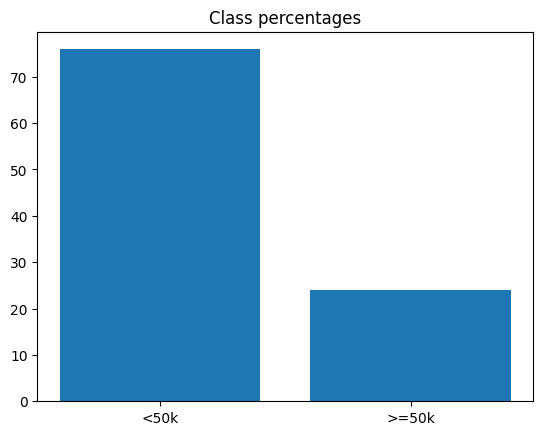

In [26]:
import matplotlib.pyplot as plt

y_pos_perc = 100 * y_train.sum().item() / len(y_train)
y_neg_perc = 100 - y_pos_perc

plt.title("Class percentages")
plt.bar(["<50k", ">=50k"], [y_neg_perc, y_pos_perc])
plt.show()

W związku z powyższym będziemy używać odpowiednich metryk, czyli AUROC, precyzji i czułości.

### Zadanie 3 (1.0 punkt)

Zaimplementuj regresję logistyczną dla tego zbioru danych, używając PyTorcha. Dane wejściowe zostały dla ciebie przygotowane w komórkach poniżej.

Sama sieć składa się z 2 elementów:
- warstwa liniowa `nn.Linear`, przekształcająca wektor wejściowy na 1 wyjście - logit
- aktywacja sigmoidalna `nn.Sigmoid`, przekształcająca logit na prawdopodobieństwo klasy pozytywnej

Użyj binarnej entropii krzyżowej `nn.BCELoss` jako funkcji kosztu. Użyj optymalizatora SGD ze stałą uczącą `1e-3`. Trenuj przez 3000 epok. Pamiętaj, aby przekazać do optymalizatora `torch.optim.SGD` parametry sieci (metoda `.parameters()`). Dopisz logowanie kosztu raz na 100 epok.

In [27]:
learning_rate = 1e-3

model = nn.Linear(X_train.shape[1], 1)
activation = nn.Sigmoid()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)
loss_fn = nn.BCELoss()

# implement me!
# your_code

for i in range(3000):
    y_hat = activation(model(X_train))
    # loss calculation
    loss = loss_fn(y_hat, y_train)

    # backpropagation
    loss.backward()

    # optimization
    optimizer.step()
    optimizer.zero_grad()  # zeroes all gradients - very convenient!

    if i % 100 == 0:
        print(f"step {i} loss: {loss.item():.4f}")

# cpu -  ~3.6s
# cuda - ~2s


step 0 loss: 0.6338
step 100 loss: 0.6117
step 200 loss: 0.5928
step 300 loss: 0.5766
step 400 loss: 0.5625
step 500 loss: 0.5503
step 600 loss: 0.5395
step 700 loss: 0.5299
step 800 loss: 0.5213
step 900 loss: 0.5135
step 1000 loss: 0.5065
step 1100 loss: 0.5001
step 1200 loss: 0.4942
step 1300 loss: 0.4888
step 1400 loss: 0.4838
step 1500 loss: 0.4792
step 1600 loss: 0.4748
step 1700 loss: 0.4707
step 1800 loss: 0.4669
step 1900 loss: 0.4633
step 2000 loss: 0.4599
step 2100 loss: 0.4567
step 2200 loss: 0.4536
step 2300 loss: 0.4507
step 2400 loss: 0.4479
step 2500 loss: 0.4453
step 2600 loss: 0.4428
step 2700 loss: 0.4404
step 2800 loss: 0.4381
step 2900 loss: 0.4359


Teraz trzeba sprawdzić, jak poszło naszej sieci. W PyTorchu sieć pracuje zawsze w jednym z dwóch trybów: treningowym lub ewaluacyjnym (predykcyjnym). Ten drugi wyłącza niektóre mechanizmy, które są używane tylko podczas treningu, w szczególności regularyzację dropout. Do przełączania służą metody modelu `.train()` i `.eval()`.

Dodatkowo podczas liczenia predykcji dobrze jest wyłączyć liczenie gradientów, bo nie będą potrzebne, a oszczędza to czas i pamięć. Używa się do tego menadżera kontekstu `with torch.no_grad():`.

In [28]:
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support, roc_auc_score


model.eval()
with torch.no_grad():
    y_score = activation(model(X_test))

auroc = roc_auc_score(y_test.cpu(), y_score.cpu())
print(f"AUROC: {auroc:.2%}")

AUROC: 85.44%


In [29]:
assert isinstance(model, nn.Linear)
assert isinstance(activation, nn.Sigmoid)
assert isinstance(optimizer, torch.optim.SGD)
assert isinstance(loss_fn, torch.nn.BCELoss)

assert model.out_features == 1
assert optimizer.param_groups[0]["lr"] == 1e-3

assert 0.0 < loss.item() < 0.5
assert 0.8 < auroc < 0.9

print("Solution is correct!")

Solution is correct!


Jest to całkiem dobry wynik, a może być jeszcze lepszy. Sprawdźmy dla pewności jeszcze inne metryki: precyzję, recall oraz F1-score. Dodatkowo narysujemy krzywą precision-recall, czyli jak zmieniają się te metryki w zależności od przyjętego progu (threshold) prawdopodobieństwa, powyżej którego przyjmujemy klasę pozytywną. Taką krzywą należy rysować na zbiorze walidacyjnym, bo później chcemy wykorzystać tę informację do doboru progu, a nie chcemy mieć wycieku danych testowych (data leakage).

Poniżej zaimplementowano także funkcję `get_optimal_threshold()`, która sprawdza, dla którego progu uzyskujemy maksymalny F1-score, i zwraca indeks oraz wartość optymalnego progu. Przyda ci się ona w dalszej części laboratorium.

In [30]:
from sklearn.metrics import PrecisionRecallDisplay


def get_optimal_threshold(
    precisions: np.array, 
    recalls: np.array, 
    thresholds: np.array
) -> Tuple[int, float]:
    
    numerator = 2 * precisions * recalls
    denominator = precisions + recalls
    f1_scores = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator != 0)
    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    return optimal_idx, optimal_threshold


def plot_precision_recall_curve(y_true, y_pred_score) -> None:
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_score)
    optimal_idx, optimal_threshold = get_optimal_threshold(precisions, recalls, thresholds)

    disp = PrecisionRecallDisplay(precisions, recalls)
    disp.plot()
    plt.title(f"Precision-recall curve (opt. thresh.: {optimal_threshold:.4f})")
    plt.axvline(recalls[optimal_idx], color="green", linestyle="-.")
    plt.axhline(precisions[optimal_idx], color="green", linestyle="-.")
    plt.show()



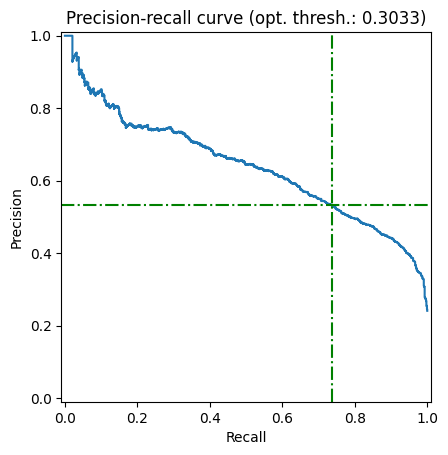

In [31]:
model.eval()
with torch.no_grad():
    y_pred_valid_score = activation(model(X_valid))

plot_precision_recall_curve(y_valid.cpu(), y_pred_valid_score.cpu())

Jak widać, chociaż AUROC jest wysokie, to dla optymalnego F1-score recall nie jest zbyt wysoki, a precyzja jest już dość niska. Być może wynik uda się poprawić, używając modelu o większej pojemności - pełnej, głębokiej sieci neuronowej.

## Sieci neuronowe

Wszystko zaczęło się od inspirowanych biologią [sztucznych neuronów](https://en.wikipedia.org/wiki/Artificial_neuron), których próbowano użyć do symulacji mózgu. Naukowcy szybko odeszli od tego podejścia (sam problem modelowania okazał się też znacznie trudniejszy, niż sądzono), zamiast tego używając neuronów jako jednostek reprezentującą dowolną funkcję parametryczną $f(x, \Theta)$. Każdy neuron jest zatem bardzo elastyczny, bo jedyne wymagania to funkcja różniczkowalna, a mamy do tego wektor parametrów $\Theta$.

W praktyce najczęściej można spotkać się z kilkoma rodzinami sieci neuronowych:
1. Perceptrony wielowarstwowe (*MultiLayer Perceptron*, MLP) - najbardziej podobne do powyższego opisu, niezbędne do klasyfikacji i regresji
2. Konwolucyjne (*Convolutional Neural Networks*, CNNs) - do przetwarzania danych z zależnościami przestrzennymi, np. obrazów czy dźwięku
3. Rekurencyjne (*Recurrent Neural Networks*, RNNs) - do przetwarzania danych z zależnościami sekwencyjnymi, np. szeregi czasowe, oraz kiedyś do języka naturalnego
4. Transformacyjne (*Transformers*), oparte o mechanizm atencji (*attention*) - do przetwarzania języka naturalnego (NLP), z którego wyparły RNNs, a coraz częściej także do wszelkich innych danych, np. obrazów, dźwięku
5. Grafowe (*Graph Neural Networks*, GNNS) - do przetwarzania grafów

Na tym laboratorium skupimy się na najprostszej architekturze, czyli MLP. Jest ona powszechnie łączona z wszelkimi innymi architekturami, bo pozwala dokonywać klasyfikacji i regresji. Przykładowo, klasyfikacja obrazów to zwykle CNN + MLP, klasyfikacja tekstów to transformer + MLP, a regresja na grafach to GNN + MLP.

Dodatkowo, pomimo prostoty MLP są bardzo potężne - udowodniono, że perceptrony (ich powszechna nazwa) są [uniwersalnym aproksymatorem](https://www.sciencedirect.com/science/article/abs/pii/0893608089900208), będącym w stanie przybliżyć dowolną funkcję z odpowiednio małym błędem, zakładając wystarczającą wielkość warstw sieci. Szczególne ich wersje potrafią nawet [reprezentować drzewa decyzyjne](https://www.youtube.com/watch?v=_okxGdHM5b8).

Dla zainteresowanych polecamy [doskonałą książkę "Dive into Deep Learning", z implementacjami w PyTorchu](https://d2l.ai/chapter_multilayer-perceptrons/index.html), [klasyczną książkę "Deep Learning Book"](https://www.deeplearningbook.org/contents/mlp.html), oraz [ten filmik](https://www.youtube.com/watch?v=BFHrIxKcLjA), jeśli zastanawiałeś/-aś się, czemu używamy deep learning, a nie naprzykład (wide?) learning. (aka. czemu staramy się budować głębokie sieci, a nie płytkie za to szerokie)

### Sieci MLP

Dla przypomnienia, na wejściu mamy punkty ze zbioru treningowego, czyli $d$-wymiarowe wektory. W klasyfikacji chcemy znaleźć granicę decyzyjną, czyli krzywą, która oddzieli od siebie klasy. W wejściowej przestrzeni może być to trudne, bo chmury punktów z poszczególnych klas mogą być ze sobą dość pomieszane. Pamiętajmy też, że regresja logistyczna jest klasyfikatorem liniowym, czyli w danej przestrzeni potrafi oddzielić punkty tylko linią prostą.

Sieć MLP składa się z warstw. Każda z nich dokonuje nieliniowego przekształcenia przestrzeni (można o tym myśleć jak o składaniu przestrzeni jakąś prostą/łamaną), tak, aby w finalnej przestrzeni nasze punkty były możliwie liniowo separowalne. Wtedy ostatnia warstwa z sigmoidą będzie potrafiła je rozdzielić od siebie.

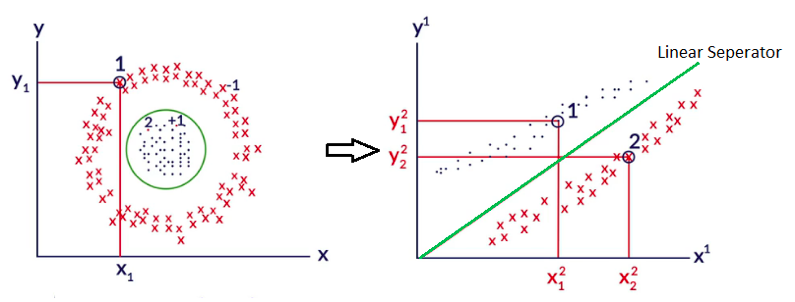

Poszczególne neurony składają się z iloczynu skalarnego wejść z wagami neuronu, oraz nieliniowej funkcji aktywacji. W PyTorchu są to osobne obiekty - `nn.Linear` oraz np. `nn.Sigmoid`. Funkcja aktywacji przyjmuje wynik iloczynu skalarnego i przekształca go, aby sprawdzić, jak mocno reaguje neuron na dane wejście. Musi być nieliniowa z dwóch powodów. Po pierwsze, tylko nieliniowe przekształcenia są na tyle potężne, żeby umożliwić liniową separację danych w ostatniej warstwie. Po drugie, liniowe przekształcenia zwyczajnie nie działają. Aby zrozumieć czemu, trzeba zobaczyć, co matematycznie oznacza sieć MLP.

![perceptron](https://www.saedsayad.com/images/Perceptron_bkp_1.png)

Zapisane matematycznie MLP to:

$\large
h_1 = f_1(x) \\
h_2 = f_2(h_1) \\
h_3 = f_3(h_2) \\
... \\
h_n = f_n(h_{n-1})
$

gdzie $x$ to wejście $f_i$ to funkcja aktywacji $i$-tej warstwy, a $h_i$ to wyjście $i$-tej warstwy, nazywane **ukrytą reprezentacją (hidden representation)**, lub *latent representation*. Nazwa bierze się z tego, że w środku sieci wyciągamy cechy i wzorce w danych, które nie są widoczne na pierwszy rzut oka na wejściu.

Załóżmy, że uczymy się na danych $x$ o jednym wymiarze (dla uproszczenia wzorów) oraz nie mamy funkcji aktywacji, czyli wykorzystujemy tak naprawdę aktywację liniową $f(x) = x$. Zobaczmy jak będą wyglądać dane przechodząc przez kolejne warstwy:

$\large
h_1 = f_1(xw_1) = xw_1 \\
h_2 = f_2(h_1w_2) = xw_1w_2 \\
... \\
h_n = f_n(h_{n-1}w_n) = xw_1w_2...w_n
$

gdzie $w_i$ to jest parametr $i$-tej warstwy sieci, $x$ to są dane (w naszym przypadku jedna liczba) wejściowa, a $h_i$ to wyjście $i$-tej warstwy.

Jak widać, taka sieć o $n$ warstwach jest równoważna sieci o jednej warstwie z parametrem $w = w_1w_2...w_n$. Wynika to z tego, że złożenie funkcji liniowych jest także funkcją liniową - patrz notatki z algebry :)

Jeżeli natomiast użyjemy nieliniowej funkcji aktywacji, często oznaczanej jako $\sigma$, to wszystko będzie działać. Co ważne, ostatnia warstwa, dająca wyjście sieci, ma zwykle inną aktywację od warstw wewnątrz sieci, bo też ma inne zadanie - zwrócić wartość dla klasyfikacji lub regresji. Na wyjściu korzysta się z funkcji liniowej (regresja), sigmoidalnej (klasyfikacja binarna) lub softmax (klasyfikacja wieloklasowa).

Wewnątrz sieci używano kiedyś sigmoidy oraz tangensa hiperbolicznego `tanh`, ale okazało się to nieefektywne przy uczeniu głębokich sieci o wielu warstwach. Nowoczesne sieci korzystają zwykle z funkcji ReLU (*rectified linear unit*), która jest zaskakująco prosta: $ReLU(x) = \max(0, x)$. Okazało się, że bardzo dobrze nadaje się do treningu nawet bardzo głębokich sieci neuronowych. Nowsze funkcje aktywacji są głównie modyfikacjami ReLU.

![relu](https://www.nomidl.com/wp-content/uploads/2022/04/image-10.png)

### MLP w PyTorchu

Warstwę neuronów w MLP nazywa się warstwą gęstą (*dense layer*) lub warstwą w pełni połączoną (*fully-connected layer*), i taki opis oznacza zwykle same neurony oraz funkcję aktywacji. PyTorch, jak już widzieliśmy, definiuje osobno transformację liniową oraz aktywację, a więc jedna warstwa składa się de facto z 2 obiektów, wywoływanych jeden po drugim. Inne frameworki, szczególnie wysokopoziomowe (np. Keras) łączą to często w jeden obiekt.

MLP składa się zatem z sekwencji obiektów, które potem wywołuje się jeden po drugim, gdzie wyjście poprzedniego to wejście kolejnego. Ale nie można tutaj używać Pythonowych list! Z perspektywy PyTorcha to wtedy niezależne obiekty i nie zostanie wtedy przekazany między nimi gradient. Trzeba tutaj skorzystać z `nn.Sequential`, aby tworzyć taki pipeline.

Rozmiary wejścia i wyjścia dla każdej warstwy trzeba w PyTorchu podawać explicite. Jest to po pierwsze edukacyjne, a po drugie często ułatwia wnioskowanie o działaniu sieci oraz jej debugowanie - mamy jasno podane, czego oczekujemy. Niektóre frameworki (np. Keras) obliczają to automatycznie.

Co ważne, ostatnia warstwa zwykle nie ma funkcji aktywacji. Wynika to z tego, że obliczanie wielu funkcji kosztu (np. entropii krzyżowej) na aktywacjach jest często niestabilne numerycznie. Z tego powodu PyTorch oferuje funkcje kosztu zawierające w środku aktywację dla ostatniej warstwy, a ich implementacje są stabilne numerycznie. Przykładowo, `nn.BCELoss` przyjmuje wejście z zaaplikowanymi już aktywacjami, ale może skutkować under/overflow, natomiast `nn.BCEWithLogitsLoss` przyjmuje wejście bez aktywacji, a w środku ma specjalną implementację łączącą binarną entropię krzyżową z aktywacją sigmoidalną. Oczywiście w związku z tym aby dokonać potem predykcji w praktyce, trzeba pamiętać o użyciu funkcji aktywacji. Często korzysta się przy tym z funkcji z modułu `torch.nn.functional`, które są w tym wypadku nieco wygodniejsze od klas wywoływalnych z `torch.nn`.

Całe sieci w PyTorchu tworzy się jako klasy dziedziczące po `nn.Module`. Co ważne, obiekty, z których tworzymy sieć, np. `nn.Linear`, także dziedziczą po tej klasie. Pozwala to na bardzo modułową budowę kodu, zgodną z zasadami OOP. W konstruktorze najpierw trzeba zawsze wywołać konstruktor rodzica - `super().__init__()`, a później tworzy się potrzebne obiekty i zapisuje jako atrybuty. Każdy atrybut dziedziczący po `nn.Module` lub `nn.Parameter` jest uważany za taki, który zawiera parametry sieci, a więc przy wywołaniu metody `parameters()` - parametry z tych atrybutów pojawią się w liście wszystkich parametrów. Musimy też zdefiniować metodę `forward()`, która przyjmuje tensor `x` i zwraca wynik. Typowo ta metoda po prostu używa obiektów zdefiniowanych w konstruktorze.


**UWAGA: nigdy w normalnych warunkach się nie woła metody `forward` ręcznie**

### Zadanie 4 (0.5 punktu)

Uzupełnij implementację 3-warstwowej sieci MLP. Użyj rozmiarów:
* pierwsza warstwa: input_size x 256
* druga warstwa: 256 x 128
* trzecia warstwa: 128 x 1

Użyj funkcji aktywacji ReLU.

Przydatne klasy:
- `nn.Sequential`
- `nn.Linear`
- `nn.ReLU`

In [32]:
from torch import sigmoid


class MLP(nn.Module):
    def __init__(self, input_size: int):
        super().__init__()

        # implement me!
        # your_code

        self.mlp = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # implement me!
        # your_code
        
        return self.mlp(x)

    def predict_proba(self, x):
        return sigmoid(self(x))
    
    def predict(self, x, threshold: float = 0.5):
        y_pred_score = self.predict_proba(x)
        return (y_pred_score > threshold).to(torch.int32)



In [33]:
# 43s
learning_rate = 1e-3
model = MLP(input_size=X_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# note that we are using loss function with sigmoid built in
loss_fn = torch.nn.BCEWithLogitsLoss()
num_epochs = 2000
evaluation_steps = 200

for i in range(num_epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    if i % evaluation_steps == 0:
        print(f"Epoch {i} train loss: {loss.item():.4f}")

print(f"final loss: {loss.item():.4f}")

Epoch 0 train loss: 0.6814
Epoch 200 train loss: 0.6607
Epoch 400 train loss: 0.6428
Epoch 600 train loss: 0.6271
Epoch 800 train loss: 0.6132
Epoch 1000 train loss: 0.6008
Epoch 1200 train loss: 0.5898
Epoch 1400 train loss: 0.5800
Epoch 1600 train loss: 0.5712
Epoch 1800 train loss: 0.5632
final loss: 0.5561


AUROC: 79.04%


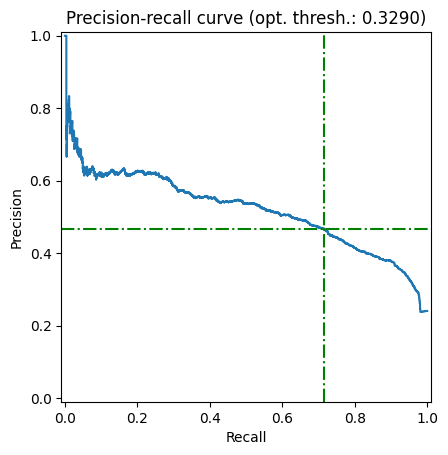

In [34]:
model.eval()
with torch.no_grad():
    # positive class probabilities
    y_pred_valid_score = model.predict_proba(X_valid)
    y_pred_test_score = model.predict_proba(X_test)

auroc = roc_auc_score(y_test.cpu(), y_pred_test_score.cpu())
print(f"AUROC: {auroc:.2%}")

plot_precision_recall_curve(y_valid.cpu(), y_pred_valid_score.cpu())

In [35]:
assert any(
    isinstance(module, nn.Linear) and module.in_features == X_train.shape[1] and module.out_features == 256
    for module in model.modules()
)

assert any(
    isinstance(module, nn.Linear) and module.in_features == 256 and module.out_features == 128
    for module in model.modules()
)

assert any(
    isinstance(module, nn.Linear) and module.in_features == 128 and module.out_features == 1
    for module in model.modules()
)

assert any(isinstance(module, nn.ReLU) for module in model.modules())

assert 0.5 < loss.item() < 0.6
assert 0.6 < auroc < 0.9

print("Solution is correct!")

Solution is correct!


AUROC jest podobne, a precision i recall spadły - wypadamy wręcz gorzej od regresji liniowej! Skoro dodaliśmy więcej warstw, to może pojemność modelu jest teraz za duża i trzeba by go zregularyzować?

Sieci neuronowe bardzo łatwo przeuczają, bo są bardzo elastycznymi i pojemnymi modelami. Dlatego mają wiele różnych rodzajów regularyzacji, których używa się razem. Co ciekawe, udowodniono eksperymentalnie, że zbyt duże sieci z mocną regularyzacją działają lepiej niż mniejsze sieci, odpowiedniego rozmiaru, za to ze słabszą regularyzacją.

Pierwszy rodzaj regularyzacji to znana nam już **regularyzacja L2**, czyli penalizacja zbyt dużych wag. W kontekście sieci neuronowych nazywa się też ją czasem *weight decay*. W PyTorchu dodaje się ją jako argument do optymalizatora.

Regularyzacja specyficzna dla sieci neuronowych to **dropout**. Polega on na losowym wyłączaniu zadanego procenta neuronów podczas treningu. Pomimo prostoty okazała się niesamowicie skuteczna, szczególnie w treningu bardzo głębokich sieci. Co ważne, jest to mechanizm używany tylko podczas treningu - w trakcie predykcji za pomocą sieci wyłącza się ten mechanizm i dokonuje normalnie predykcji całą siecią. Podejście to można potraktować jak ensemble learning, podobny do lasów losowych - wyłączając losowe części sieci, w każdej iteracji trenujemy nieco inną sieć, co odpowiada uśrednianiu predykcji różnych algorytmów. Typowo stosuje się dość mocny dropout, rzędu 25-50%. W PyTorchu implementuje go warstwa `nn.Dropout`, aplikowana zazwyczaj po funkcji aktywacji.

Ostatni, a być może najważniejszy rodzaj regularyzacji to **wczesny stop (early stopping)**. W każdym kroku mocniej dostosowujemy terenową sieć do zbioru treningowego, a więc zbyt długi trening będzie skutkował przeuczeniem. W metodzie wczesnego stopu używamy wydzielonego zbioru walidacyjnego (pojedynczego, metoda holdout), sprawdzając co określoną liczbę epok wynik na tym zbiorze. Jeżeli nie uzyskamy wyniku lepszego od najlepszego dotychczas uzyskanego przez określoną liczbę epok, to przerywamy trening. Okres, przez który czekamy na uzyskanie lepszego wyniku, to cierpliwość (*patience*). Im mniejsze, tym mocniejszy jest ten rodzaj regularyzacji, ale trzeba z tym uważać, bo łatwo jest przesadzić i zbyt szybko przerywać trening. Niektóre implementacje uwzględniają tzw. *grace period*, czyli gwarantowaną minimalną liczbę epok, przez którą będziemy trenować sieć, niezależnie od wybranej cierpliwości.

Dodatkowo ryzyko przeuczenia można zmniejszyć, używając mniejszej stałej uczącej.

### Zadanie 5 (1.5 punktu)

Zaimplementuj funkcję `evaluate_model()`, obliczającą metryki na zbiorze testowym:
- wartość funkcji kosztu (loss)
- AUROC
- optymalny próg
- F1-score przy optymalnym progu
- precyzję oraz recall dla optymalnego progu

Jeżeli podana jest wartość argumentu `threshold`, to użyj jej do zamiany prawdopodobieństw na twarde predykcje. W przeciwnym razie użyj funkcji `get_optimal_threshold` i oblicz optymalną wartość progu.

Pamiętaj o przełączeniu modelu w tryb ewaluacji oraz o wyłączeniu obliczania gradientów.

In [36]:
from typing import Optional

from sklearn.metrics import precision_score, recall_score, f1_score
from torch import sigmoid


def evaluate_model(
    model: nn.Module, 
    X: torch.Tensor, 
    y: torch.Tensor, 
    loss_fn: nn.Module,
    threshold: Optional[float] = None
) -> Dict[str, float]:
    # implement me!
    # your_code
    
    model.eval()

    with torch.no_grad():
        y_pred_score = model.predict_proba(X).cpu()

        _, optimal_threshold = get_optimal_threshold(*precision_recall_curve(y.cpu(), y_pred_score))

        y_pred = model.predict(X, threshold if threshold is not None else optimal_threshold).cpu()

        loss = loss_fn(model(X), y).item()

        y_cpu = y.cpu()

        auroc = roc_auc_score(y_cpu, y_pred_score)
        precision = precision_score(y_cpu, y_pred)
        recall = recall_score(y_cpu, y_pred)
        f1 = f1_score(y_cpu, y_pred)

    return {
        'loss': loss,
        'AUROC': auroc,
        'optimal_threshold': optimal_threshold,
        'precision': precision,
        'F1-score': f1,
        'precision': precision,
        'recall': recall
    }


In [37]:
eval_result = evaluate_model(model, X_train, y_train, loss_fn)

assert 0.5 < eval_result["loss"] < 0.6
assert 0.6 < eval_result["AUROC"] < 0.9
assert 0.3 < eval_result["precision"] < 0.6
assert 0.6 < eval_result["recall"] < 0.9
assert 0.4 < eval_result["F1-score"] < 0.7

print("Solution is correct!")

Solution is correct!


### Zadanie 6 (0.5 punktu)

Zaimplementuj 3-warstwową sieć MLP z dropout (50%). Rozmiary warstw ukrytych mają wynosić 256 i 128.

In [38]:
class RegularizedMLP(nn.Module):
    def __init__(self, input_size: int, dropout_p: float = 0.5):
        super().__init__()

        # implement me!
        # your_code
        self.mlp = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        # implement me!
        # your_code
        return self.mlp(x)

    def predict_proba(self, x):
        return sigmoid(self(x))
    
    def predict(self, x, threshold: float = 0.5):
        y_pred_score = self.predict_proba(x)
        return (y_pred_score > threshold).to(torch.int32)



In [39]:
verification_input_size = 143
verification_dropout_p = 0.125
verification_model = RegularizedMLP(
    input_size=verification_input_size,
    dropout_p=verification_dropout_p,
)

assert any(
    isinstance(module, nn.Linear) and module.in_features == verification_input_size and module.out_features == 256
    for module in verification_model.modules()
)

assert any(
    isinstance(module, nn.Linear) and module.in_features == 256 and module.out_features == 128
    for module in verification_model.modules()
)

assert any(
    isinstance(module, nn.Linear) and module.in_features == 128 and module.out_features == 1
    for module in verification_model.modules()
)

assert any(isinstance(module, nn.Dropout) and module.p == verification_dropout_p for module in verification_model.modules())
assert any(isinstance(module, nn.ReLU) for module in verification_model.modules())

print("Solution is correct!")

Solution is correct!


Opisaliśmy wcześniej podstawowy optymalizator w sieciach neuronowych - spadek wzdłuż gradientu. Jednak wymaga on użycia całego zbioru danych, aby obliczyć gradient, co jest często niewykonalne przez rozmiar zbioru. Dlatego wymyślono **stochastyczny spadek wzdłuż gradientu (stochastic gradient descent, SGD)**, w którym używamy 1 przykładu naraz, liczymy gradient tylko po nim i aktualizujemy parametry. Jest to oczywiście dość grube przybliżenie gradientu, ale pozwala robić szybko dużo małych kroków. Kompromisem, którego używa się w praktyce, jest **minibatch gradient descent**, czyli używanie batchy np. 32, 64 czy 128 przykładów.

Rzadko wspominanym, a ważnym faktem jest także to, że stochastyczność metody optymalizacji jest sama w sobie też [metodą regularyzacji](https://arxiv.org/abs/2101.12176), a więc `batch_size` to także hiperparametr.

Obecnie najpopularniejszą odmianą SGD jest [Adam](https://arxiv.org/abs/1412.6980), gdyż uczy on szybko sieć oraz daje bardzo dobre wyniki nawet przy niekoniecznie idealnie dobranych hiperparametrach. W PyTorchu najlepiej korzystać z jego implementacji `AdamW`, która jest nieco lepsza niż implementacja `Adam`. Jest to zasadniczo zawsze wybór domyślny przy treningu współczesnych sieci neuronowych.

Na razie użyjemy jednak minibatch SGD.

Poniżej znajduje się implementacja prostej klasy dziedziczącej po `Dataset` - tak w PyTorchu implementuje się własne zbiory danych. Użycie takich klas umożliwia użycie klas ładujących dane (`DataLoader`), które z kolei pozwalają łatwo ładować batche danych. Trzeba w takiej klasie zaimplementować metody:
- `__len__` - zwraca ilość punktów w zbiorze
- `__getitem__` - zwraca przykład ze zbioru pod danym indeksem oraz jego klasę


In [40]:
from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self, data, y):
        super().__init__()
        
        self.data = data
        self.y = y
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx], self.y[idx]



### Zadanie 7 (1.5 punktu)

Zaimplementuj pętlę treningowo-walidacyjną dla sieci neuronowej. Wykorzystaj podane wartości hiperparametrów do treningu (stała ucząca, prawdopodobieństwo dropoutu, regularyzacja L2, rozmiar batcha, maksymalna liczba epok). Użyj optymalizatora SGD.

Dodatkowo zaimplementuj regularyzację przez early stopping. Sprawdzaj co epokę wynik na zbiorze walidacyjnym. Użyj podanej wartości patience, a jako metryki po prostu wartości funkcji kosztu. Może się tutaj przydać zaimplementowana funkcja `evaluate_model()`.

Pamiętaj o tym, aby przechowywać najlepszy dotychczasowy wynik walidacyjny oraz najlepszy dotychczasowy model. Zapamiętaj też optymalny próg do klasyfikacji dla najlepszego modelu.

In [41]:
from copy import deepcopy

from torch.utils.data import DataLoader


learning_rate = 1e-3
dropout_p = 0.5
l2_reg = 1e-4
batch_size = 128
max_epochs = 300

early_stopping_patience = 4

In [42]:
# 1m
model = RegularizedMLP(
    input_size=X_train.shape[1], 
    dropout_p=dropout_p
)
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=l2_reg
)
loss_fn = torch.nn.BCEWithLogitsLoss()

train_dataset = MyDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

steps_without_improvement = 0

best_val_loss = np.inf
best_model = None
best_threshold = None

for epoch_num in range(max_epochs):
    model.train()
    
    # note that we are using DataLoader to get batches
    for X_batch, y_batch in train_dataloader:
        # model training
        # implement me!
        # your_code

        
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    
    # model evaluation, early stopping
    # implement me!
    # your_code

    valid_metrics = evaluate_model(model, X_valid, y_valid, loss_fn)
    print(f"Epoch {epoch_num} train loss: {loss.item():.4f}, eval loss {valid_metrics['loss']:.4f}")
    if valid_metrics['loss'] < best_val_loss:
        best_val_loss = valid_metrics['loss']
        best_model = deepcopy(model)
        best_threshold = valid_metrics['optimal_threshold']
        
        steps_without_improvement = 0
    else:
        steps_without_improvement += 1
        print(f'{steps_without_improvement} step without improvement', end="")
        if steps_without_improvement >= early_stopping_patience:
            print(', early stop!')
            break

Epoch 0 train loss: 0.6840, eval loss 0.6813
Epoch 1 train loss: 0.6668, eval loss 0.6628
Epoch 2 train loss: 0.6439, eval loss 0.6468
Epoch 3 train loss: 0.6309, eval loss 0.6327
Epoch 4 train loss: 0.6224, eval loss 0.6201
Epoch 5 train loss: 0.6083, eval loss 0.6089
Epoch 6 train loss: 0.5990, eval loss 0.5989
Epoch 7 train loss: 0.5833, eval loss 0.5898
Epoch 8 train loss: 0.5795, eval loss 0.5816
Epoch 9 train loss: 0.5700, eval loss 0.5742
Epoch 10 train loss: 0.5643, eval loss 0.5674
Epoch 11 train loss: 0.5580, eval loss 0.5613
Epoch 12 train loss: 0.5538, eval loss 0.5556
Epoch 13 train loss: 0.5391, eval loss 0.5504
Epoch 14 train loss: 0.5365, eval loss 0.5456
Epoch 15 train loss: 0.5426, eval loss 0.5411
Epoch 16 train loss: 0.5347, eval loss 0.5369
Epoch 17 train loss: 0.5178, eval loss 0.5329
Epoch 18 train loss: 0.5289, eval loss 0.5290
Epoch 19 train loss: 0.5222, eval loss 0.5253
Epoch 20 train loss: 0.5189, eval loss 0.5217
Epoch 21 train loss: 0.5358, eval loss 0.518

In [43]:
test_metrics = evaluate_model(best_model, X_test, y_test, loss_fn, best_threshold)

print(f"AUROC: {test_metrics['AUROC']:.2%}")
print(f"F1: {test_metrics['F1-score']:.2%}")
print(f"Precision: {test_metrics['precision']:.2%}")
print(f"Recall: {test_metrics['recall']:.2%}")

AUROC: 90.25%
F1: 69.07%
Precision: 63.56%
Recall: 75.64%


In [44]:
assert test_metrics["AUROC"] > 0.8
assert test_metrics["F1-score"] > 0.6
assert test_metrics["precision"] > 0.5
assert test_metrics["recall"] > 0.6

print("Solution is correct!")

Solution is correct!


Wyniki wyglądają już dużo lepiej.

Na koniec laboratorium dołożymy do naszego modelu jeszcze 3 powrzechnie używane techniki, które są bardzo proste, a pozwalają często ulepszyć wynik modelu.

Pierwszą z nich są **warstwy normalizacji (normalization layers)**. Powstały one początkowo z założeniem, że przez przekształcenia przestrzeni dokonywane przez sieć zmienia się rozkład prawdopodobieństw pomiędzy warstwami, czyli tzw. *internal covariate shift*. Później okazało się, że zastosowanie takiej normalizacji wygładza powierzchnię funkcji kosztu, co ułatwia i przyspiesza optymalizację. Najpowszechniej używaną normalizacją jest **batch normalization (batch norm)**.

Drugim ulepszeniem jest dodanie **wag klas (class weights)**. Mamy do czynienia z problemem klasyfikacji niezbalansowanej, więc klasa mniejszościowa, ważniejsza dla nas, powinna dostać większą wagę. Implementuje się to trywialnie prosto - po prostu mnożymy wartość funkcji kosztu dla danego przykładu przez wagę dla prawdziwej klasy tego przykładu. Praktycznie każdy klasyfikator operujący na jakiejś ważonej funkcji może działać w ten sposób, nie tylko sieci neuronowe.

Ostatnim ulepszeniem jest zamiana SGD na optymalizator Adam, a konkretnie na optymalizator `AdamW`. Jest to przykład **optymalizatora adaptacyjnego (adaptive optimizer)**, który potrafi zaadaptować stałą uczącą dla każdego parametru z osobna w trakcie treningu. Wykorzystuje do tego gradienty - w uproszczeniu, im większa wariancja gradientu, tym mniejsze kroki w tym kierunku robimy.

### Zadanie 8 (0.5 punktu)

Zaimplementuj model `NormalizingMLP`, o takiej samej strukturze jak `RegularizedMLP`, ale dodatkowo z warstwami `BatchNorm1d` pomiędzy warstwami `Linear` oraz `ReLU`.

Za pomocą funkcji `compute_class_weight()` oblicz wagi dla poszczególnych klas. Użyj opcji `"balanced"`. Przekaż do funkcji kosztu wagę klasy pozytywnej (pamiętaj, aby zamienić ją na tensor).

Zamień używany optymalizator na `AdamW`.

Na koniec skopiuj resztę kodu do treningu z poprzedniego zadania, wytrenuj sieć i oblicz wyniki na zbiorze testowym.

In [45]:
class NormalizingMLP(nn.Module):
    def __init__(self, input_size: int, dropout_p: float = 0.5):
        super().__init__()

        # implement me!
        # your_code
        self.mlp = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.mlp(x)

    def predict_proba(self, x):
        return sigmoid(self(x))
    
    def predict(self, x, threshold: float = 0.5):
        y_pred_score = self.predict_proba(x)
        return (y_pred_score > threshold).to(torch.int32)



In [46]:
# define all the hyperparameters
# your_code

from sklearn.utils.class_weight import compute_class_weight

y_train_cpu = y_train.cpu()

weights = compute_class_weight(class_weight = 'balanced', y = y_train_cpu.numpy()[:, 0], classes = np.unique(y_train_cpu))

learning_rate = 1e-3
dropout_p = 0.5
l2_reg = 1e-4
batch_size = 128
max_epochs = 300

early_stopping_patience = 4

torch_weights = torch.from_numpy(weights)[1].to('cuda')
print(torch_weights.device)


cuda:0


In [47]:
# training loop
# your_code
model = NormalizingMLP(
    input_size=X_train.shape[1], 
    dropout_p=dropout_p
)
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=l2_reg
)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight = torch_weights)

train_dataset = MyDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

steps_without_improvement = 0

best_val_loss = np.inf
best_model = None
best_threshold = None

for epoch_num in range(max_epochs):
    model.train()
    
    # note that we are using DataLoader to get batches
    for X_batch, y_batch in train_dataloader:
        # model training
        # implement me!
        # your_code

        
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    
    # model evaluation, early stopping
    # implement me!
    # your_code

    valid_metrics = evaluate_model(model, X_valid, y_valid, loss_fn)
    print(f"Epoch {epoch_num} train loss: {loss.item():.4f}, eval loss {valid_metrics['loss']:.4f}")
    if valid_metrics['loss'] < best_val_loss:
        best_val_loss = valid_metrics['loss']
        best_model = deepcopy(model)
        best_threshold = valid_metrics['optimal_threshold']
        
        steps_without_improvement = 0
    else:
        steps_without_improvement += 1
        print(f'{steps_without_improvement} step without improvement', end="")
        if steps_without_improvement >= early_stopping_patience:
            print(', early stop!')
            break
        else:
            print()

Epoch 0 train loss: 0.5648, eval loss 0.4809
Epoch 1 train loss: 0.5691, eval loss 0.4742
Epoch 2 train loss: 0.5655, eval loss 0.4718
Epoch 3 train loss: 0.6149, eval loss 0.4705
Epoch 4 train loss: 0.5646, eval loss 0.4726
1 step without improvement
Epoch 5 train loss: 0.5631, eval loss 0.4726
2 step without improvement
Epoch 6 train loss: 0.5194, eval loss 0.4738
3 step without improvement
Epoch 7 train loss: 0.5282, eval loss 0.4732
4 step without improvement, early stop!


In [48]:
test_metrics = evaluate_model(best_model, X_test, y_test, loss_fn, best_threshold)

print(f"AUROC: {test_metrics['AUROC']:.2%}")
print(f"F1: {test_metrics['F1-score']:.2%}")
print(f"Precision: {test_metrics['precision']:.2%}")
print(f"Recall: {test_metrics['recall']:.2%}")

AUROC: 90.75%
F1: 69.46%
Precision: 65.46%
Recall: 73.98%


In [49]:
verification_input_size = 143
verification_dropout_p = 0.125
verification_model = NormalizingMLP(
    input_size=verification_input_size,
    dropout_p=verification_dropout_p,
)

assert any(
    isinstance(module, nn.Linear) and module.in_features == verification_input_size and module.out_features == 256
    for module in verification_model.modules()
)

assert any(
    isinstance(module, nn.Linear) and module.in_features == 256 and module.out_features == 128
    for module in verification_model.modules()
)

assert any(
    isinstance(module, nn.Linear) and module.in_features == 128 and module.out_features == 1
    for module in verification_model.modules()
)

assert any(isinstance(module, nn.Dropout) and module.p == verification_dropout_p for module in verification_model.modules())
assert any(isinstance(module, nn.ReLU) for module in verification_model.modules())

assert any(isinstance(module, nn.BatchNorm1d) for module in verification_model.modules())

assert test_metrics["AUROC"] > 0.8
assert test_metrics["F1-score"] > 0.6
assert test_metrics["precision"] > 0.5
assert test_metrics["recall"] > 0.6

print("Solution is correct!")

Solution is correct!


## Akceleracja sprzętowa (dla zainteresowanych)

Jak wcześniej wspominaliśmy, użycie akceleracji sprzętowej, czyli po prostu GPU do obliczeń, jest bardzo efektywne w przypadku sieci neuronowych. Karty graficzne bardzo efektywnie mnożą macierze, a sieci neuronowe to, jak można było się przekonać, dużo mnożenia macierzy.

W PyTorchu jest to dosyć łatwe, ale trzeba robić to explicite. Służy do tego metoda `.to()`, która przenosi tensory między CPU i GPU. Poniżej przykład, jak to się robi (oczywiście trzeba mieć skonfigurowane GPU, żeby działało):

In [50]:
import time 


class CudaMLP(nn.Module):
    def __init__(self, input_size: int, dropout_p: float = 0.5):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(128, 1),
        )
    
    def forward(self, x):
        return self.mlp(x)

    def predict_proba(self, x):
        return sigmoid(self(x))
    
    def predict(self, x, threshold: float = 0.5):
        y_pred_score = self.predict_proba(x)
        return (y_pred_score > threshold).to(torch.int32)


model = CudaMLP(X_train.shape[1]).to('cuda')

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# note that we are using loss function with sigmoid built in
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.from_numpy(weights)[1].to('cuda'))

step_counter = 0
time_from_eval = time.time()
for epoch_id in range(30):
    for batch_x, batch_y in train_dataloader:
        batch_x = batch_x.to('cuda')
        batch_y = batch_y.to('cuda')
        
        loss = loss_fn(model(batch_x), batch_y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        if step_counter % evaluation_steps == 0:
            print(f"Epoch {epoch_id} train loss: {loss.item():.4f}, time: {time.time() - time_from_eval}")
            time_from_eval = time.time()

        step_counter += 1

test_res = evaluate_model(model.to('cpu'), X_test.cpu(), y_test.cpu(), loss_fn.to('cpu'), threshold=0.5)

print(f"AUROC: {test_res['AUROC']:.2%}")
print(f"F1: {test_res['F1-score']:.2%}")
print(test_res)

Epoch 0 train loss: 0.9058, time: 0.008997678756713867
Epoch 1 train loss: 0.4669, time: 1.3666388988494873
Epoch 2 train loss: 0.5030, time: 1.3666021823883057
Epoch 3 train loss: 0.4047, time: 1.3529374599456787
Epoch 4 train loss: 0.5978, time: 1.3725581169128418
Epoch 6 train loss: 0.3286, time: 1.3217473030090332
Epoch 7 train loss: 0.4238, time: 1.3028984069824219
Epoch 8 train loss: 0.4500, time: 1.2791502475738525
Epoch 9 train loss: 0.4168, time: 1.2880134582519531
Epoch 11 train loss: 0.4704, time: 1.3014090061187744
Epoch 12 train loss: 0.3986, time: 1.283517837524414
Epoch 13 train loss: 0.5061, time: 1.2109456062316895
Epoch 14 train loss: 0.3665, time: 1.214087963104248
Epoch 15 train loss: 0.4363, time: 1.3136472702026367
Epoch 17 train loss: 0.3291, time: 1.249096155166626
Epoch 18 train loss: 0.4495, time: 1.2598814964294434
Epoch 19 train loss: 0.4054, time: 1.2658283710479736
Epoch 20 train loss: 0.4451, time: 1.2212514877319336
Epoch 22 train loss: 0.4206, time: 1.2

Co prawda ten model nie będzie tak dobry jak ten z laboratorium, ale zwróć uwagę, o ile jest większy, a przy tym szybszy.

Dla zainteresowanych polecamy [tę serie artykułów](https://medium.com/@adi.fu7/ai-accelerators-part-i-intro-822c2cdb4ca4)

## Zadanie dla chętnych

Jak widzieliśmy, sieci neuronowe mają bardzo dużo hiperparametrów. Przeszukiwanie ich grid search'em jest więc niewykonalne, a chociaż random search by działał, to potrzebowałby wielu iteracji, co też jest kosztowne obliczeniowo.

Zaimplementuj inteligentne przeszukiwanie przestrzeni hiperparametrów za pomocą biblioteki [Optuna](https://optuna.org/). Implementuje ona między innymi algorytm Tree Parzen Estimator (TPE), należący do grupy algorytmów typu Bayesian search. Typowo osiągają one bardzo dobre wyniki, a właściwie zawsze lepsze od przeszukiwania losowego. Do tego wystarcza im często niewielka liczba kroków.

Zaimplementuj 3-warstwową sieć MLP, gdzie pierwsza warstwa ma rozmiar ukryty N, a druga N // 2. Ucz ją optymalizatorem Adam przez maksymalnie 300 epok z cierpliwością 10.

Przeszukaj wybrane zakresy dla hiperparametrów:
- rozmiar warstw ukrytych (N)
- stała ucząca
- batch size
- siła regularyzacji L2
- prawdopodobieństwo dropoutu

Wykorzystaj przynajmniej 30 iteracji. Następnie przełącz algorytm na losowy (Optuna także jego implementuje), wykonaj 30 iteracji i porównaj jakość wyników.

Przydatne materiały:
- [Optuna code examples - PyTorch](https://optuna.org/#code_examples)
- [Auto-Tuning Hyperparameters with Optuna and PyTorch](https://www.youtube.com/watch?v=P6NwZVl8ttc)
- [Hyperparameter Tuning of Neural Networks with Optuna and PyTorch](https://towardsdatascience.com/hyperparameter-tuning-of-neural-networks-with-optuna-and-pytorch-22e179efc837)
- [Using Optuna to Optimize PyTorch Hyperparameters](https://medium.com/pytorch/using-optuna-to-optimize-pytorch-hyperparameters-990607385e36)

In [51]:
import optuna

class OptunaMLP(nn.Module):
    def __init__(self, input_size: int, N: int, dropout_p: float = 0.5):
        super().__init__()

        # implement me!
        # your_code
        self.mlp = nn.Sequential(
            nn.Linear(input_size, N),
            nn.BatchNorm1d(N),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(N, N//2),
            nn.BatchNorm1d(N//2),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(N//2, 1)
        )
    
    def forward(self, x):
        # print(f'x = {x}')
        return self.mlp(x)

    def predict_proba(self, x):
        return sigmoid(self(x))
    
    def predict(self, x, threshold: float = 0.5):
        y_pred_score = self.predict_proba(x)
        return (y_pred_score > threshold).to(torch.int32)
    
# learning_rate = 1e-3
# dropout_p = 0.5
# l2_reg = 1e-4
# batch_size = 128
# max_epochs = 300

# early_stopping_patience = 4

class MLPWrapper:
    def __init__(self, learning_rate, dropout_p, l2_reg, batch_size, N, pos_weight, max_epochs = 300, early_stopping_patience = 5):
        self.learning_rate = learning_rate
        self.dropout_p = dropout_p
        self.l2_reg = l2_reg
        self.batch_size = batch_size
        self.N = N
        self.pos_weights = pos_weight
        self.max_epochs = max_epochs
        self.early_stopping_patience = early_stopping_patience

        self.model = OptunaMLP(X_train.shape[1], N, dropout_p).cuda()
        self.optimizer = optim.AdamW(params = self.model.parameters(), lr = learning_rate, weight_decay = l2_reg)
        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

        self.loss_ = np.inf
        self.model_ = None
        self.threshold_ = None

    def fit(self, X_train, y_train, X_valid, y_valid):
        train_dataset = MyDataset(X_train, y_train)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

        steps_without_improvement = 0

        for epoch_num in range(self.max_epochs):
            self.model.train()
            #print(f"Model device: {next(self.model.parameters()).device}")

            for X_batch, y_batch in train_dataloader:
                #print(f"X_batch device: {X_batch.device}, y_batch device: {y_batch.device}")
                y_pred = self.model(X_batch)
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()

                self.optimizer.step()
                self.optimizer.zero_grad()
            
            valid_metrics = evaluate_model(self.model, X_valid, y_valid, self.loss_fn)
            #rint(f"Epoch {epoch_num} train loss: {loss.item():.4f}, eval loss {valid_metrics['loss']:.4f}")
            if valid_metrics['loss'] < self.loss_:
                self.loss_ = valid_metrics['loss']
                self.model_ = deepcopy(self.model)
                self.threshold_ = valid_metrics['optimal_threshold']
                
                steps_without_improvement = 0
            else:
                steps_without_improvement += 1
                #print(f'{steps_without_improvement} step without improvement', end="")
                if steps_without_improvement >= self.early_stopping_patience:
                    #print(', early stop!')
                    break

    def predict_proba(self, X):
        return self.model_.predict_proba(X)
    
    def predict(self, X, threshold = None):
        return self.model_.predict(X, threshold if threshold is not None else self.threshold_)


In [52]:
def objective(trial: optuna.Trial):
    learning_rate = trial.suggest_float('learning_rate', low = 0.00001, high = 0.1)
    dropout_p = trial.suggest_float('dropout_p', low = 0.25, high = 0.5)
    l2_reg = trial.suggest_float('l2_reg', low = 0.00001, high = 0.001)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256, 512])
    N = trial.suggest_categorical('N', [64, 128, 256, 512, 1024, 2048])

    model = MLPWrapper(learning_rate, dropout_p, l2_reg, batch_size, N, torch_weights)

    model.fit(X_train, y_train, X_valid, y_valid)
    with torch.no_grad():
        return roc_auc_score(y_test.cpu(), model.predict_proba(X_test).cpu())

In [53]:
study1 = optuna.create_study(direction = 'maximize', sampler = optuna.samplers.TPESampler())
study1.optimize(objective, n_trials = 30, n_jobs = -1, show_progress_bar = True)
study2 = optuna.create_study(direction = 'maximize', sampler = optuna.samplers.RandomSampler())
study2.optimize(objective, n_trials = 30, n_jobs = -1, show_progress_bar = True)

print(f'TPESampler:\n\tbest_value = {study1.best_value}\n\tbest_params = {study1.best_params}\nRandomSampler:\n\tbest_value = {study2.best_value}\n\tbest_params = {study2.best_params}\n')

[I 2024-11-28 09:20:36,133] A new study created in memory with name: no-name-dd3e7fef-b0c5-465e-90c7-bbb0d355fca2
Best trial: 3. Best value: 0.903322:   3%|▎         | 1/30 [00:38<18:29, 38.25s/it]

[I 2024-11-28 09:21:14,384] Trial 3 finished with value: 0.9033217432574647 and parameters: {'learning_rate': 0.09353229595253582, 'dropout_p': 0.47926741294235764, 'l2_reg': 0.00017641115726285277, 'batch_size': 256, 'N': 256}. Best is trial 3 with value: 0.9033217432574647.


Best trial: 5. Best value: 0.903804:   7%|▋         | 2/30 [00:41<08:12, 17.60s/it]

[I 2024-11-28 09:21:17,513] Trial 5 finished with value: 0.9038044123109304 and parameters: {'learning_rate': 0.07439047646456515, 'dropout_p': 0.3626986544218946, 'l2_reg': 0.0008807580927205676, 'batch_size': 512, 'N': 64}. Best is trial 5 with value: 0.9038044123109304.


Best trial: 10. Best value: 0.904792:  10%|█         | 3/30 [00:43<04:41, 10.44s/it]

[I 2024-11-28 09:21:19,452] Trial 10 finished with value: 0.9047918687191763 and parameters: {'learning_rate': 0.059280114458236235, 'dropout_p': 0.2605912437043276, 'l2_reg': 0.0007535490003384109, 'batch_size': 512, 'N': 128}. Best is trial 10 with value: 0.9047918687191763.


Best trial: 8. Best value: 0.906313:  13%|█▎        | 4/30 [00:46<03:17,  7.61s/it] 

[I 2024-11-28 09:21:22,704] Trial 8 finished with value: 0.9063133886011432 and parameters: {'learning_rate': 0.06602342299632126, 'dropout_p': 0.2595642765361127, 'l2_reg': 0.0003232394877894716, 'batch_size': 256, 'N': 128}. Best is trial 8 with value: 0.9063133886011432.


Best trial: 1. Best value: 0.906423:  17%|█▋        | 5/30 [00:53<03:04,  7.36s/it]

[I 2024-11-28 09:21:29,633] Trial 1 finished with value: 0.9064230773199068 and parameters: {'learning_rate': 0.0839456336738985, 'dropout_p': 0.4042593904682805, 'l2_reg': 0.00012192814192255658, 'batch_size': 512, 'N': 256}. Best is trial 1 with value: 0.9064230773199068.


Best trial: 1. Best value: 0.906423:  20%|██        | 6/30 [01:00<02:54,  7.27s/it]

[I 2024-11-28 09:21:36,717] Trial 11 finished with value: 0.9046317528528096 and parameters: {'learning_rate': 0.09996749243364941, 'dropout_p': 0.30672534355179226, 'l2_reg': 0.0001353605512264535, 'batch_size': 128, 'N': 128}. Best is trial 1 with value: 0.9064230773199068.


Best trial: 1. Best value: 0.906423:  23%|██▎       | 7/30 [01:02<02:06,  5.50s/it]

[I 2024-11-28 09:21:38,548] Trial 0 finished with value: 0.9046641242442377 and parameters: {'learning_rate': 0.09826377375027465, 'dropout_p': 0.26134980341571007, 'l2_reg': 0.000908469878785165, 'batch_size': 64, 'N': 64}. Best is trial 1 with value: 0.9064230773199068.


Best trial: 1. Best value: 0.906423:  27%|██▋       | 8/30 [01:04<01:34,  4.27s/it]

[I 2024-11-28 09:21:40,220] Trial 9 finished with value: 0.906301587874786 and parameters: {'learning_rate': 0.027578658569631546, 'dropout_p': 0.46610265764756353, 'l2_reg': 0.000283893635142471, 'batch_size': 512, 'N': 512}. Best is trial 1 with value: 0.9064230773199068.


Best trial: 1. Best value: 0.906423:  30%|███       | 9/30 [01:05<01:13,  3.51s/it]

[I 2024-11-28 09:21:42,053] Trial 4 finished with value: 0.9061984121252141 and parameters: {'learning_rate': 0.051813495010871236, 'dropout_p': 0.2910007467944753, 'l2_reg': 0.0008226456768951942, 'batch_size': 256, 'N': 128}. Best is trial 1 with value: 0.9064230773199068.


Best trial: 2. Best value: 0.907826:  33%|███▎      | 10/30 [01:06<00:54,  2.70s/it]

[I 2024-11-28 09:21:42,949] Trial 2 finished with value: 0.9078257516353355 and parameters: {'learning_rate': 0.03313352890979703, 'dropout_p': 0.459156888866002, 'l2_reg': 0.0008729082618377721, 'batch_size': 32, 'N': 64}. Best is trial 2 with value: 0.9078257516353355.


Best trial: 2. Best value: 0.907826:  37%|███▋      | 11/30 [01:16<01:29,  4.69s/it]

[I 2024-11-28 09:21:52,129] Trial 7 finished with value: 0.9057510162811333 and parameters: {'learning_rate': 0.048934283740616924, 'dropout_p': 0.3077664044065668, 'l2_reg': 0.00017637650432817553, 'batch_size': 512, 'N': 128}. Best is trial 2 with value: 0.9078257516353355.


Best trial: 2. Best value: 0.907826:  40%|████      | 12/30 [01:31<02:22,  7.93s/it]

[I 2024-11-28 09:22:07,491] Trial 14 finished with value: 0.9056136635645158 and parameters: {'learning_rate': 0.02905863799848361, 'dropout_p': 0.40745750204281517, 'l2_reg': 0.0004517881179085692, 'batch_size': 256, 'N': 512}. Best is trial 2 with value: 0.9078257516353355.


Best trial: 2. Best value: 0.907826:  43%|████▎     | 13/30 [01:32<01:37,  5.75s/it]

[I 2024-11-28 09:22:08,234] Trial 12 finished with value: 0.907476114813974 and parameters: {'learning_rate': 0.020128901521756674, 'dropout_p': 0.4570115897043268, 'l2_reg': 0.0007397733465917031, 'batch_size': 64, 'N': 256}. Best is trial 2 with value: 0.9078257516353355.


Best trial: 2. Best value: 0.907826:  47%|████▋     | 14/30 [01:34<01:18,  4.88s/it]

[I 2024-11-28 09:22:11,086] Trial 15 finished with value: 0.906826945894637 and parameters: {'learning_rate': 0.008305960264587959, 'dropout_p': 0.43210284947004907, 'l2_reg': 0.00048333860726198125, 'batch_size': 256, 'N': 512}. Best is trial 2 with value: 0.9078257516353355.


Best trial: 2. Best value: 0.907826:  50%|█████     | 15/30 [01:45<01:40,  6.68s/it]

[I 2024-11-28 09:22:21,934] Trial 6 finished with value: 0.9064579636202308 and parameters: {'learning_rate': 0.04092172829066519, 'dropout_p': 0.38389930177281806, 'l2_reg': 0.0006729029569410868, 'batch_size': 512, 'N': 64}. Best is trial 2 with value: 0.9078257516353355.


Best trial: 2. Best value: 0.907826:  53%|█████▎    | 16/30 [01:48<01:15,  5.42s/it]

[I 2024-11-28 09:22:24,435] Trial 16 finished with value: 0.9052268189884649 and parameters: {'learning_rate': 0.08428113746210046, 'dropout_p': 0.44428351794541393, 'l2_reg': 0.0003714488833551047, 'batch_size': 512, 'N': 512}. Best is trial 2 with value: 0.9078257516353355.


Best trial: 2. Best value: 0.907826:  57%|█████▋    | 17/30 [01:50<00:56,  4.37s/it]

[I 2024-11-28 09:22:26,378] Trial 13 finished with value: 0.9072773725263614 and parameters: {'learning_rate': 0.08227252041868974, 'dropout_p': 0.40703023649424713, 'l2_reg': 0.0003883181132487948, 'batch_size': 256, 'N': 512}. Best is trial 2 with value: 0.9078257516353355.


Best trial: 2. Best value: 0.907826:  60%|██████    | 18/30 [01:51<00:41,  3.44s/it]

[I 2024-11-28 09:22:27,650] Trial 19 finished with value: 0.9049632694331525 and parameters: {'learning_rate': 0.03173766979195185, 'dropout_p': 0.2647737791661281, 'l2_reg': 0.0008515805969843377, 'batch_size': 128, 'N': 512}. Best is trial 2 with value: 0.9078257516353355.


Best trial: 2. Best value: 0.907826:  63%|██████▎   | 19/30 [01:52<00:29,  2.68s/it]

[I 2024-11-28 09:22:28,563] Trial 21 finished with value: 0.9063792276263387 and parameters: {'learning_rate': 0.0027956551417324324, 'dropout_p': 0.4297227150618915, 'l2_reg': 0.0005979703208849559, 'batch_size': 32, 'N': 2048}. Best is trial 2 with value: 0.9078257516353355.


Best trial: 2. Best value: 0.907826:  67%|██████▋   | 20/30 [01:57<00:35,  3.53s/it]

[I 2024-11-28 09:22:34,067] Trial 18 finished with value: 0.9058498715461918 and parameters: {'learning_rate': 0.060594552387281404, 'dropout_p': 0.3971507587970028, 'l2_reg': 0.00011691644831229486, 'batch_size': 32, 'N': 256}. Best is trial 2 with value: 0.9078257516353355.


Best trial: 2. Best value: 0.907826:  70%|███████   | 21/30 [01:58<00:24,  2.75s/it]

[I 2024-11-28 09:22:34,990] Trial 20 finished with value: 0.9056148242916985 and parameters: {'learning_rate': 0.09542338634179394, 'dropout_p': 0.26827142824563954, 'l2_reg': 0.0003332114309338485, 'batch_size': 128, 'N': 64}. Best is trial 2 with value: 0.9078257516353355.


Best trial: 2. Best value: 0.907826:  73%|███████▎  | 22/30 [02:00<00:19,  2.43s/it]

[I 2024-11-28 09:22:36,697] Trial 22 finished with value: 0.9059133891170219 and parameters: {'learning_rate': 0.011550644390231998, 'dropout_p': 0.43679029056980156, 'l2_reg': 0.0005744561626319299, 'batch_size': 32, 'N': 2048}. Best is trial 2 with value: 0.9078257516353355.


Best trial: 2. Best value: 0.907826:  77%|███████▋  | 23/30 [02:11<00:35,  5.04s/it]

[I 2024-11-28 09:22:47,818] Trial 24 finished with value: 0.9057882885206661 and parameters: {'learning_rate': 0.008192168484875039, 'dropout_p': 0.43554818624613895, 'l2_reg': 0.0006581599159209139, 'batch_size': 32, 'N': 2048}. Best is trial 2 with value: 0.9078257516353355.


Best trial: 2. Best value: 0.907826:  80%|████████  | 24/30 [02:12<00:22,  3.69s/it]

[I 2024-11-28 09:22:48,371] Trial 23 finished with value: 0.9058669600297145 and parameters: {'learning_rate': 0.016682899291533035, 'dropout_p': 0.42572356954111834, 'l2_reg': 0.0006122239679742813, 'batch_size': 32, 'N': 1024}. Best is trial 2 with value: 0.9078257516353355.


Best trial: 2. Best value: 0.907826:  83%|████████▎ | 25/30 [02:14<00:16,  3.31s/it]

[I 2024-11-28 09:22:50,801] Trial 25 finished with value: 0.9074331034233714 and parameters: {'learning_rate': 0.0003496180955718034, 'dropout_p': 0.4963637939584783, 'l2_reg': 0.0006749529963703151, 'batch_size': 32, 'N': 1024}. Best is trial 2 with value: 0.9078257516353355.


Best trial: 2. Best value: 0.907826:  87%|████████▋ | 26/30 [02:15<00:09,  2.45s/it]

[I 2024-11-28 09:22:51,219] Trial 27 finished with value: 0.9061962196405356 and parameters: {'learning_rate': 0.0012001647897387849, 'dropout_p': 0.49662827782137536, 'l2_reg': 0.0006545634513480858, 'batch_size': 32, 'N': 2048}. Best is trial 2 with value: 0.9078257516353355.


Best trial: 2. Best value: 0.907826:  90%|█████████ | 27/30 [02:15<00:05,  1.89s/it]

[I 2024-11-28 09:22:51,826] Trial 28 finished with value: 0.90681959462248 and parameters: {'learning_rate': 0.0016292108330445594, 'dropout_p': 0.49571460049291793, 'l2_reg': 0.0006313999823563102, 'batch_size': 32, 'N': 1024}. Best is trial 2 with value: 0.9078257516353355.


Best trial: 2. Best value: 0.907826:  93%|█████████▎| 28/30 [02:16<00:03,  1.65s/it]

[I 2024-11-28 09:22:52,892] Trial 29 finished with value: 0.9069998297600133 and parameters: {'learning_rate': 0.00685370920318323, 'dropout_p': 0.49436815370851384, 'l2_reg': 0.0006275866979650991, 'batch_size': 32, 'N': 1024}. Best is trial 2 with value: 0.9078257516353355.


Best trial: 2. Best value: 0.907826:  97%|█████████▋| 29/30 [02:17<00:01,  1.41s/it]

[I 2024-11-28 09:22:53,747] Trial 26 finished with value: 0.9062164678813891 and parameters: {'learning_rate': 0.00302150351549273, 'dropout_p': 0.4946245263878454, 'l2_reg': 0.0006488177718146361, 'batch_size': 32, 'N': 1024}. Best is trial 2 with value: 0.9078257516353355.


Best trial: 2. Best value: 0.907826: 100%|██████████| 30/30 [02:18<00:00,  4.60s/it]
[I 2024-11-28 09:22:54,213] A new study created in memory with name: no-name-73620efd-bc32-45bb-8f44-f3894c4e4d4a


[I 2024-11-28 09:22:54,210] Trial 17 finished with value: 0.90417771506985 and parameters: {'learning_rate': 0.08268058839909995, 'dropout_p': 0.25661517553477603, 'l2_reg': 0.0007473969086116833, 'batch_size': 128, 'N': 256}. Best is trial 2 with value: 0.9078257516353355.


Best trial: 7. Best value: 0.904766:   3%|▎         | 1/30 [00:39<19:04, 39.47s/it]

[I 2024-11-28 09:23:33,671] Trial 7 finished with value: 0.9047656878727224 and parameters: {'learning_rate': 0.05451525705856816, 'dropout_p': 0.35244637238767795, 'l2_reg': 0.00033306277664430086, 'batch_size': 32, 'N': 2048}. Best is trial 7 with value: 0.9047656878727224.


Best trial: 5. Best value: 0.90589:   7%|▋         | 2/30 [00:40<07:47, 16.69s/it] 

[I 2024-11-28 09:23:34,414] Trial 5 finished with value: 0.9058897876643074 and parameters: {'learning_rate': 0.09635005761584085, 'dropout_p': 0.3036684998691901, 'l2_reg': 0.0001343945966497527, 'batch_size': 512, 'N': 1024}. Best is trial 5 with value: 0.9058897876643074.


Best trial: 8. Best value: 0.906575:  10%|█         | 3/30 [00:44<04:54, 10.90s/it]

[I 2024-11-28 09:23:38,437] Trial 8 finished with value: 0.9065747456717773 and parameters: {'learning_rate': 0.0019531965152756463, 'dropout_p': 0.46501989060978877, 'l2_reg': 0.0006132233378897859, 'batch_size': 64, 'N': 512}. Best is trial 8 with value: 0.9065747456717773.


Best trial: 8. Best value: 0.906575:  13%|█▎        | 4/30 [00:45<03:04,  7.11s/it]

[I 2024-11-28 09:23:39,734] Trial 9 finished with value: 0.9057818400363179 and parameters: {'learning_rate': 0.09331628794585002, 'dropout_p': 0.27334183047962923, 'l2_reg': 0.00010042700178674468, 'batch_size': 256, 'N': 2048}. Best is trial 8 with value: 0.9065747456717773.


Best trial: 8. Best value: 0.906575:  17%|█▋        | 5/30 [00:47<02:10,  5.23s/it]

[I 2024-11-28 09:23:41,641] Trial 1 finished with value: 0.9064395854398383 and parameters: {'learning_rate': 0.023929622325544506, 'dropout_p': 0.4287368866512639, 'l2_reg': 1.3767509492889617e-05, 'batch_size': 64, 'N': 2048}. Best is trial 8 with value: 0.9065747456717773.


Best trial: 8. Best value: 0.906575:  20%|██        | 6/30 [00:58<02:50,  7.09s/it]

[I 2024-11-28 09:23:52,332] Trial 4 finished with value: 0.9060513866820742 and parameters: {'learning_rate': 0.0089298329630131, 'dropout_p': 0.4499089924276813, 'l2_reg': 0.0002455615307269645, 'batch_size': 32, 'N': 64}. Best is trial 8 with value: 0.9065747456717773.


Best trial: 2. Best value: 0.906936:  27%|██▋       | 8/30 [00:59<01:17,  3.54s/it]

[I 2024-11-28 09:23:53,368] Trial 10 finished with value: 0.9060896261942594 and parameters: {'learning_rate': 0.09454044655073941, 'dropout_p': 0.48594007042803544, 'l2_reg': 0.00014631515166821265, 'batch_size': 512, 'N': 256}. Best is trial 8 with value: 0.9065747456717773.
[I 2024-11-28 09:23:53,543] Trial 2 finished with value: 0.9069362477043397 and parameters: {'learning_rate': 0.05824858968729609, 'dropout_p': 0.39072651484009, 'l2_reg': 0.00030194814737092966, 'batch_size': 256, 'N': 64}. Best is trial 2 with value: 0.9069362477043397.


Best trial: 2. Best value: 0.906936:  30%|███       | 9/30 [01:01<01:02,  2.97s/it]

[I 2024-11-28 09:23:55,273] Trial 3 finished with value: 0.9059511772353026 and parameters: {'learning_rate': 0.07965517892315085, 'dropout_p': 0.4683563338993286, 'l2_reg': 0.0004563409777917783, 'batch_size': 256, 'N': 128}. Best is trial 2 with value: 0.9069362477043397.


Best trial: 2. Best value: 0.906936:  33%|███▎      | 10/30 [01:07<01:19,  3.99s/it]

[I 2024-11-28 09:24:01,535] Trial 11 finished with value: 0.9061911898227439 and parameters: {'learning_rate': 0.0048991843350763425, 'dropout_p': 0.4504431190825898, 'l2_reg': 0.0009225907238508752, 'batch_size': 64, 'N': 128}. Best is trial 2 with value: 0.9069362477043397.


Best trial: 0. Best value: 0.907518:  37%|███▋      | 11/30 [01:12<01:24,  4.46s/it]

[I 2024-11-28 09:24:07,062] Trial 0 finished with value: 0.9075178365077072 and parameters: {'learning_rate': 0.01154871948003373, 'dropout_p': 0.4209138291943435, 'l2_reg': 0.0008576789860359423, 'batch_size': 32, 'N': 64}. Best is trial 0 with value: 0.9075178365077072.


Best trial: 0. Best value: 0.907518:  40%|████      | 12/30 [01:16<01:13,  4.08s/it]

[I 2024-11-28 09:24:10,285] Trial 6 finished with value: 0.9058902390582119 and parameters: {'learning_rate': 0.07888990046220688, 'dropout_p': 0.4767824607452179, 'l2_reg': 0.000944309024576551, 'batch_size': 64, 'N': 512}. Best is trial 0 with value: 0.9075178365077072.


Best trial: 0. Best value: 0.907518:  43%|████▎     | 13/30 [01:19<01:04,  3.81s/it]

[I 2024-11-28 09:24:13,484] Trial 16 finished with value: 0.9028806669280453 and parameters: {'learning_rate': 0.060253577790775, 'dropout_p': 0.3307984950641151, 'l2_reg': 0.00044453528828012197, 'batch_size': 64, 'N': 2048}. Best is trial 0 with value: 0.9075178365077072.


Best trial: 0. Best value: 0.907518:  47%|████▋     | 14/30 [01:32<01:44,  6.53s/it]

[I 2024-11-28 09:24:26,296] Trial 12 finished with value: 0.9061982831555271 and parameters: {'learning_rate': 0.005137233116454152, 'dropout_p': 0.4065004810306664, 'l2_reg': 0.00019472149279329184, 'batch_size': 64, 'N': 64}. Best is trial 0 with value: 0.9075178365077072.


Best trial: 0. Best value: 0.907518:  50%|█████     | 15/30 [01:39<01:41,  6.80s/it]

[I 2024-11-28 09:24:33,705] Trial 13 finished with value: 0.9068725366789789 and parameters: {'learning_rate': 0.001681786485972454, 'dropout_p': 0.3429660317298657, 'l2_reg': 3.529981652444406e-05, 'batch_size': 512, 'N': 512}. Best is trial 0 with value: 0.9075178365077072.


Best trial: 0. Best value: 0.907518:  53%|█████▎    | 16/30 [01:42<01:17,  5.53s/it]

[I 2024-11-28 09:24:36,311] Trial 17 finished with value: 0.905623981139473 and parameters: {'learning_rate': 0.07672554356690402, 'dropout_p': 0.43617756123218804, 'l2_reg': 0.0002781260780713815, 'batch_size': 256, 'N': 2048}. Best is trial 0 with value: 0.9075178365077072.


Best trial: 0. Best value: 0.907518:  57%|█████▋    | 17/30 [01:43<00:55,  4.28s/it]

[I 2024-11-28 09:24:37,685] Trial 19 finished with value: 0.9070169827283796 and parameters: {'learning_rate': 0.0016472417547080567, 'dropout_p': 0.430971794668091, 'l2_reg': 0.0005906518510411353, 'batch_size': 32, 'N': 512}. Best is trial 0 with value: 0.9075178365077072.


Best trial: 0. Best value: 0.907518:  60%|██████    | 18/30 [01:48<00:54,  4.50s/it]

[I 2024-11-28 09:24:42,693] Trial 14 finished with value: 0.9058081498524587 and parameters: {'learning_rate': 0.09286710722488319, 'dropout_p': 0.3662893506649617, 'l2_reg': 0.0001138103499077928, 'batch_size': 256, 'N': 2048}. Best is trial 0 with value: 0.9075178365077072.


Best trial: 0. Best value: 0.907518:  63%|██████▎   | 19/30 [01:53<00:51,  4.65s/it]

[I 2024-11-28 09:24:47,694] Trial 22 finished with value: 0.9050963016652566 and parameters: {'learning_rate': 0.09328350267178653, 'dropout_p': 0.2723320340578476, 'l2_reg': 0.0007334532940321723, 'batch_size': 32, 'N': 2048}. Best is trial 0 with value: 0.9075178365077072.


Best trial: 0. Best value: 0.907518:  67%|██████▋   | 20/30 [01:56<00:42,  4.23s/it]

[I 2024-11-28 09:24:50,957] Trial 21 finished with value: 0.9071789686552072 and parameters: {'learning_rate': 0.015077029199328153, 'dropout_p': 0.28695248195842393, 'l2_reg': 0.0007385173710403396, 'batch_size': 128, 'N': 128}. Best is trial 0 with value: 0.9075178365077072.


Best trial: 0. Best value: 0.907518:  70%|███████   | 21/30 [01:58<00:31,  3.49s/it]

[I 2024-11-28 09:24:52,698] Trial 20 finished with value: 0.9062067951548668 and parameters: {'learning_rate': 0.017046816202365617, 'dropout_p': 0.48380299349203504, 'l2_reg': 0.0007492497235012936, 'batch_size': 256, 'N': 512}. Best is trial 0 with value: 0.9075178365077072.


Best trial: 0. Best value: 0.907518:  73%|███████▎  | 22/30 [02:02<00:30,  3.77s/it]

[I 2024-11-28 09:24:57,143] Trial 23 finished with value: 0.9063867078681827 and parameters: {'learning_rate': 0.0006852131755070945, 'dropout_p': 0.2813359701027002, 'l2_reg': 0.0008679840687325549, 'batch_size': 32, 'N': 2048}. Best is trial 0 with value: 0.9075178365077072.


Best trial: 0. Best value: 0.907518:  77%|███████▋  | 23/30 [02:03<00:19,  2.74s/it]

[I 2024-11-28 09:24:57,482] Trial 18 finished with value: 0.9064569963475786 and parameters: {'learning_rate': 0.0076837921555838965, 'dropout_p': 0.390547776311928, 'l2_reg': 0.00026280486444645517, 'batch_size': 256, 'N': 256}. Best is trial 0 with value: 0.9075178365077072.


Best trial: 0. Best value: 0.907518:  80%|████████  | 24/30 [02:05<00:16,  2.73s/it]

[I 2024-11-28 09:25:00,189] Trial 27 finished with value: 0.9046543870328717 and parameters: {'learning_rate': 0.024067973059218727, 'dropout_p': 0.32821138968878993, 'l2_reg': 0.0001156790215097448, 'batch_size': 256, 'N': 512}. Best is trial 0 with value: 0.9075178365077072.


Best trial: 0. Best value: 0.907518:  83%|████████▎ | 25/30 [02:07<00:11,  2.38s/it]

[I 2024-11-28 09:25:01,733] Trial 25 finished with value: 0.9059752945667651 and parameters: {'learning_rate': 0.04289785945286885, 'dropout_p': 0.2835594870946807, 'l2_reg': 0.00034891885083205665, 'batch_size': 256, 'N': 1024}. Best is trial 0 with value: 0.9075178365077072.


Best trial: 0. Best value: 0.907518:  87%|████████▋ | 26/30 [02:10<00:10,  2.62s/it]

[I 2024-11-28 09:25:04,914] Trial 28 finished with value: 0.9062181444873196 and parameters: {'learning_rate': 0.03714353325650221, 'dropout_p': 0.471686133011028, 'l2_reg': 0.00015770584332595834, 'batch_size': 128, 'N': 2048}. Best is trial 0 with value: 0.9075178365077072.


Best trial: 0. Best value: 0.907518:  90%|█████████ | 27/30 [02:14<00:08,  2.89s/it]

[I 2024-11-28 09:25:08,441] Trial 24 finished with value: 0.9050432306390706 and parameters: {'learning_rate': 0.08049296061086696, 'dropout_p': 0.35161681895490804, 'l2_reg': 0.00018128409353855137, 'batch_size': 64, 'N': 128}. Best is trial 0 with value: 0.9075178365077072.


Best trial: 0. Best value: 0.907518:  93%|█████████▎| 28/30 [02:14<00:04,  2.11s/it]

[I 2024-11-28 09:25:08,734] Trial 26 finished with value: 0.9071854171395556 and parameters: {'learning_rate': 0.058215191318971536, 'dropout_p': 0.478721637724307, 'l2_reg': 0.0004822738452338842, 'batch_size': 32, 'N': 64}. Best is trial 0 with value: 0.9075178365077072.


Best trial: 15. Best value: 0.907712:  97%|█████████▋| 29/30 [02:14<00:01,  1.57s/it]

[I 2024-11-28 09:25:09,039] Trial 15 finished with value: 0.9077118714017457 and parameters: {'learning_rate': 0.0001379563276265752, 'dropout_p': 0.2749845740336709, 'l2_reg': 6.466505714245966e-05, 'batch_size': 256, 'N': 512}. Best is trial 15 with value: 0.9077118714017457.


Best trial: 15. Best value: 0.907712: 100%|██████████| 30/30 [02:17<00:00,  4.60s/it]

[I 2024-11-28 09:25:12,112] Trial 29 finished with value: 0.9051044912403787 and parameters: {'learning_rate': 0.09732610355205944, 'dropout_p': 0.3531550544971074, 'l2_reg': 0.0009327683170385124, 'batch_size': 128, 'N': 128}. Best is trial 15 with value: 0.9077118714017457.
TPESampler:
	best_value = 0.9078257516353355
	best_params = {'learning_rate': 0.03313352890979703, 'dropout_p': 0.459156888866002, 'l2_reg': 0.0008729082618377721, 'batch_size': 32, 'N': 64}
RandomSampler:
	best_value = 0.9077118714017457
	best_params = {'learning_rate': 0.0001379563276265752, 'dropout_p': 0.2749845740336709, 'l2_reg': 6.466505714245966e-05, 'batch_size': 256, 'N': 512}

